# DS project: predicting song popularity by genre - Kathy Li, Sa Qu, Rulan Xiao

## Data preparation

In [1]:
import numpy as np
import scipy
import os
import sklearn as skl
import pandas as pd
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import pylab as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# Load metadata and features - change to local directory for tracks file
tracks = pd.read_csv('tracks.csv', header=None)
echonest = pd.read_csv('echonest.csv', header=None)

C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,11,13,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,1

In [3]:
# Change column names from "track.1", ... to named columns
header = tracks.iloc[1]
header[0] = 'track_ID'
tracks.drop(tracks.index[[0,1,2]], inplace=True)
tracks.rename(columns=header, inplace=True)

header = echonest.iloc[2]
header[0]='track_ID'
echonest.drop(echonest.index[[0,1,2,3]],inplace=True)
echonest.rename(columns = header,inplace=True)

# Only select songs for which we have echonest data
tracks_with_echonest_data = tracks[tracks['track_ID'].isin(echonest['track_ID'])]
echonest_data = echonest[echonest['track_ID'].isin(tracks_with_echonest_data['track_ID'])]

merged_echonest_data = pd.merge(tracks_with_echonest_data, echonest_data, on = 'track_ID')

# Change duplicate "listens" column to track listens and album listens
duplicate_listens = {'listens': ['album_listens', 'track_listens']}

merged_echonest_data = merged_echonest_data.rename(columns=lambda c: duplicate_listens[c].pop(0) if c in duplicate_listens.keys() else c)

In [4]:
# Extract year released from release date variable
album_release_year = []

for x in merged_echonest_data['date_released']:
    if type(x)==str:
        album_release_year.append(x[0:4])
    else: 
        album_release_year.append(np.nan)

#add album release year to dataframe
merged_echonest_data['album_release_year'] = album_release_year

# Check number of songs released per year and pick year with maximum
import collections
counter=collections.Counter(album_release_year)
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(3))

Counter({nan: 3140, '2010': 1461, '2009': 1426, '2011': 1101, '2008': 1088, '2007': 464, '2012': 380, '2006': 346, '2013': 298, '2014': 245, '2004': 167, '2005': 150, '2015': 145, '2003': 94, '2002': 84, '2001': 69, '1999': 68, '2000': 34, '1997': 25, '1995': 20, '1982': 19, '1998': 17, '1996': 10, '1986': 10, '1981': 6, '1973': 5, '1985': 5, '1992': 3, '1913': 2, '1976': 2, '1912': 1, '1916': 1, '1911': 1, '1909': 1, '1905': 1, '1907': 1, '1988': 1, '1902': 1})
dict_values([1426, 1088, 464, 150, 20, 346, 3140, 94, 19, 6, 69, 84, 167, 34, 68, 10, 1, 1, 1, 2, 1, 1, 1, 25, 3, 1, 17, 1461, 2, 10, 1101, 5, 245, 380, 298, 5, 1, 145])
dict_keys(['2009', '2008', '2007', '2005', '1995', '2006', nan, '2003', '1982', '1981', '2001', '2002', '2004', '2000', '1999', '1996', '1912', '1916', '1911', '1913', '1909', '1905', '1907', '1997', '1992', '1988', '1998', '2010', '1976', '1986', '2011', '1973', '2014', '2012', '2013', '1985', '1902', '2015'])
[(nan, 3140), ('2010', 1461), ('2009', 1426)]


In [5]:
# For chosen year, check the number of songs released per genre; pick top three genres to use
tracks_2010 = merged_echonest_data[merged_echonest_data['album_release_year'] == '2010']

# Top genres for 2010
counter=collections.Counter(tracks_2010['genre_top'])
print(counter)
print(counter.values())
print(counter.keys())
print(counter.most_common(10))

Counter({nan: 524, 'Rock': 372, 'Electronic': 271, 'Hip-Hop': 133, 'Folk': 67, 'Pop': 58, 'Jazz': 23, 'International': 12, 'Instrumental': 1})
dict_values([23, 372, 58, 271, 524, 133, 67, 12, 1])
dict_keys(['Jazz', 'Rock', 'Pop', 'Electronic', nan, 'Hip-Hop', 'Folk', 'International', 'Instrumental'])
[(nan, 524), ('Rock', 372), ('Electronic', 271), ('Hip-Hop', 133), ('Folk', 67), ('Pop', 58), ('Jazz', 23), ('International', 12), ('Instrumental', 1)]


In [6]:
# Add sentiment analysis by title into dataset - compound score of positive / negative sentiment for song title
# require to install nltk first
# this part work nice, file will be generated to our project folder. 

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Read in track data - change to local directory
tracks_senti = pd.read_csv('tracks.csv',header=None)

header = tracks_senti.iloc[1]
header[0]='track ID'
header[52]='track title'
tracks_senti.drop(tracks_senti.index[[0,1,2]],inplace=True)
tracks_senti.rename(columns = header,inplace=True)
tracks_senti.head()

df=tracks_senti[['track ID','track title']]
df.dropna(axis=0, how='any')

ml = df["track title"].values
title=[]
for i in range(len(ml)):
    a=str(ml[i])
    title.append(a)
idd = df["track ID"].values

neg=[]
neu=[]
pos=[]
comp=[]

sid = SentimentIntensityAnalyzer()
for sentence in title:
    ss = sid.polarity_scores(sentence)
    score=[]
    for k in ss:
        a=ss[k]
        score.append(a)
    neg.append(score[0])
    neu.append(score[1])
    pos.append(score[2])
    comp.append(score[3])

#sentimentall = pd.DataFrame({'track_ID':idd,'track_title':title,'senti neg': neg,'senti neu': neu,'senti pos': pos,'senti comp': comp})

#sentimentall.to_csv('sentimental_analysis_title.csv')

C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\qusac\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,1,5,6,8,12,18,20,21,22,24,33,34,38,39,44,47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# Add sentiment to dataframe
sentiment= pd.read_csv('sentimental_analysis_title.csv')
sentiment=sentiment[['track_ID','senti comp', 'senti neg','senti pos']]
tracks_2010 = pd.merge(tracks_2010, sentiment, how='inner', on=['track_ID'])
tracks_2010.head()

track_ID comments         date_created        date_released engineer  \
0    26531        0  2010-03-02 06:00:32  2010-03-02 00:00:00      NaN   
1    26532        0  2010-03-02 06:00:32  2010-03-02 00:00:00      NaN   
2    26533        0  2010-03-02 06:00:32  2010-03-02 00:00:00      NaN   
3    26534        0  2010-03-02 06:00:32  2010-03-02 00:00:00      NaN   
4    27223        0  2010-03-14 11:40:47  2010-03-14 00:00:00      NaN   

  favorites    id                                        information  \
0         2  5763  <p>Improvising music is probably the best exam...   
1         2  5763  <p>Improvising music is probably the best exam...   
2         2  5763  <p>Improvising music is probably the best exam...   
3         2  5763  <p>Improvising music is probably the best exam...   
4         3  5883  <p>The Sakee Sed are Marco Grezzi and Gianluca...   

  album_listens producer    ...           218      219      220      221  \
0          7260      NaN    ...     0.0947888  0.06272  3.30952   3.2468   
1          7260      NaN    ...      0.556985  0.07887  10.1641  10.0852   
2          7260      NaN    ...      0.131889  0.06363  8.14385  8.08022   
3          7260      NaN    ...      0.118238  0.06381  7.81628  7.75247   
4          6282      NaN    ...     0.0100094  0.08762  0.70132   0.6137   

       222      223 album_release_year senti comp senti neg senti pos  
0   3.4673  19.3287               2010        0.0       0.0       0.0  
1    6.203  52.9757               2010        0.0       0.0       0.0  
2  8.10984  117.875               2010        0.0       0.0       0.0  
3  8.11471  123.621               2010        0.0       0.0       0.0  
4  1.18583  2.11265               2010        0.0       0.0       0.0  

[5 rows x 306 columns]

In [8]:
# Select the variables we want - named variables 
t10 = tracks_2010[['track_ID','latitude','longitude','bit_rate','duration','genre_top','track_listens','acousticness','danceability','energy','instrumentalness','liveness','speechiness','tempo','valence','artist_hotttnesss','artist_discovery','artist_familiarity', 'senti neg','senti pos']]
t10['popular'] = (t10['track_listens']>=1147.25).astype(int)
# For location (latitude, longitude), if na, change to 0
t10['latitude'].fillna(0, inplace=True)
t10['longitude'].fillna(0, inplace=True)

# For genre-specific models - split dataset into three based on top three genres
Hiphop_10=t10.loc[t10['genre_top'] == 'Hip-Hop']
Rock_10=t10.loc[t10['genre_top'] == 'Rock']
Elec_10=t10.loc[t10['genre_top'] == 'Electronic']

# For baseline model - add genre as a categorical variable 
t10['Rock'] = (t10['genre_top'] == 'Rock').astype(int)
t10['Hip-Hop'] = (t10['genre_top'] == 'Hip-Hop').astype(int)
t10['Electronic'] = (t10['genre_top'] == 'Electronic').astype(int)
t10.drop(['genre_top'], axis=1, inplace=True)

t10.astype(int).describe()

C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

track_ID     latitude    longitude       bit_rate     duration  \
count    1461.000000  1461.000000  1461.000000    1461.000000  1461.000000   
mean    39464.459274    27.995209   -20.156057  278633.140999   254.431896   
std     13616.675320    23.739467    49.874242   54456.429805   159.329293   
min     26531.000000   -40.000000  -122.000000  105073.000000    34.000000   
25%     32468.000000     0.000000   -73.000000  256000.000000   172.000000   
50%     36430.000000    39.000000     0.000000  320000.000000   230.000000   
75%     40931.000000    45.000000     5.000000  320000.000000   300.000000   
max    124911.000000    61.000000   174.000000  321934.000000  2367.000000   

       track_listens  acousticness  danceability  energy  instrumentalness  \
count    1461.000000        1461.0        1461.0  1461.0            1461.0   
mean     2082.902806           0.0           0.0     0.0               0.0   
std      7401.443595           0.0           0.0     0.0               0.0   
min        25.000000           0.0           0.0     0.0               0.0   
25%       275.000000           0.0           0.0     0.0               0.0   
50%       677.000000           0.0           0.0     0.0               0.0   
75%      1615.000000           0.0           0.0     0.0               0.0   
max    178139.000000           0.0           0.0     0.0               0.0   

          ...       valence  artist_hotttnesss  artist_discovery  \
count     ...        1461.0             1461.0            1461.0   
mean      ...           0.0                0.0               0.0   
std       ...           0.0                0.0               0.0   
min       ...           0.0                0.0               0.0   
25%       ...           0.0                0.0               0.0   
50%       ...           0.0                0.0               0.0   
75%       ...           0.0                0.0               0.0   
max       ...           0.0                0.0               0.0   

       artist_familiarity    senti neg    senti pos      popular         Rock  \
count              1461.0  1461.000000  1461.000000  1461.000000  1461.000000   
mean                  0.0     0.008898     0.010267     0.338809     0.254620   
std                   0.0     0.093941     0.100839     0.473467     0.435797   
min                   0.0     0.000000     0.000000     0.000000     0.000000   
25%                   0.0     0.000000     0.000000     0.000000     0.000000   
50%                   0.0     0.000000     0.000000     0.000000     0.000000   
75%                   0.0     0.000000     0.000000     1.000000     1.000000   
max                   0.0     1.000000     1.000000     1.000000     1.000000   

           Hip-Hop   Electronic  
count  1461.000000  1461.000000  
mean      0.091034     0.185489  
std       0.287755     0.388827  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     0.000000  
max       1.000000     1.000000  

[8 rows x 23 columns]

In [9]:
# Take hip-hop, rock, and hip-hop together
t10['g']=t10['Rock']+ t10['Hip-Hop'] +t10['Electronic']
t10=t10.loc[t10['g'] == 1]
t10.drop(['g'],axis=1,inplace=True)

# only genres Hiphop, Rock and Electronic (separate dataframes)
Hiphop_10.drop(['genre_top'],axis=1,inplace=True)
Rock_10.drop(['genre_top'],axis=1,inplace=True)
Elec_10.drop(['genre_top'],axis=1,inplace=True)

C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


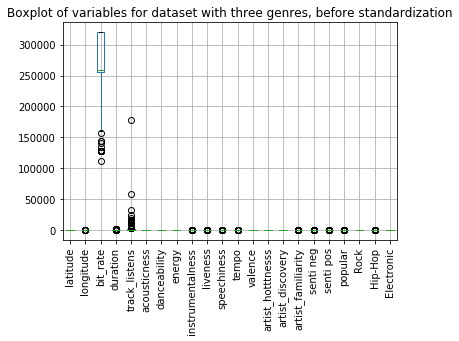

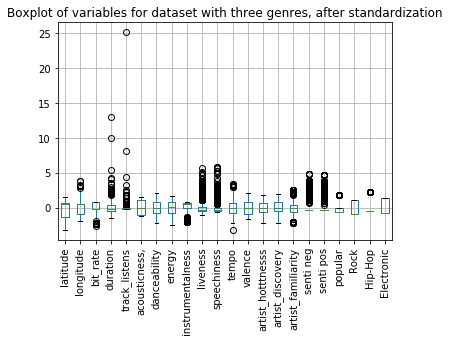

In [10]:
# Make boxplot of variables for t10 data (data with all three genres) - before standardization 
t10.drop(['track_ID'], axis=1).astype(float).boxplot()
plt.title('Boxplot of variables for dataset with three genres, before standardization')
plt.xticks(rotation=90)
plt.show()

# Make boxplot of variables for t10 data (data with all three genres) - after standardization 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
t10_scaled = scaler.fit_transform(t10.drop(['track_ID'], axis=1))
t10_scaled = pd.DataFrame(t10_scaled)
t10_scaled.rename(columns={0: 'latitude', 1:'longitude',2:'bit_rate',3:'duration',4:'track_listens',5:'acousticness,',6:'danceability',7:'energy',8:'instrumentalness',9:'liveness',10:'speechiness',11:'tempo',12:'valence',13:'artist_hotttnesss',14:'artist_discovery',15:'artist_familiarity',16:'senti neg',17:'senti pos',18:'popular',19:'Rock',20:'Hip-Hop',21:'Electronic'}, inplace=True)

t10_scaled.astype(float).boxplot()
plt.title('Boxplot of variables for dataset with three genres, after standardization')
plt.xticks(rotation=90)
plt.show()

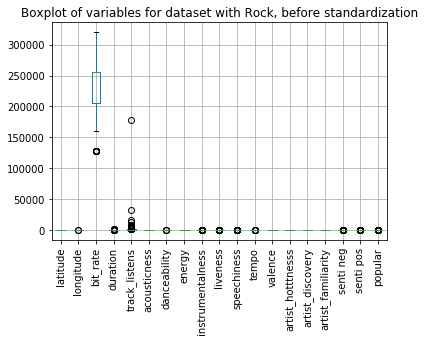

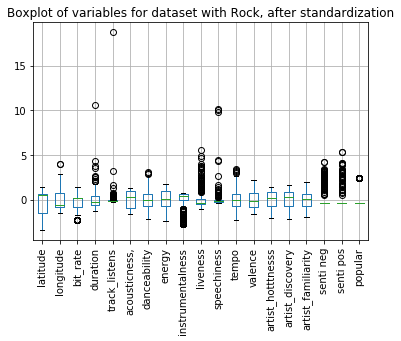

In [11]:
# Make boxplot of variables for rock data - before standardization 
Rock_10.drop(['track_ID'], axis=1).astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Rock, before standardization')
plt.xticks(rotation=90)
plt.show()

# Make boxplot of variables for rock data - after standardization 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Rock_10_scaled = scaler.fit_transform(Rock_10.drop(['track_ID'], axis=1))
Rock_10_scaled = pd.DataFrame(Rock_10_scaled)
Rock_10_scaled.rename(columns={0: 'latitude', 1:'longitude',2:'bit_rate',3:'duration',4:'track_listens',5:'acousticness,',6:'danceability',7:'energy',8:'instrumentalness',9:'liveness',10:'speechiness',11:'tempo',12:'valence',13:'artist_hotttnesss',14:'artist_discovery',15:'artist_familiarity',16:'senti neg',17:'senti pos',18:'popular',19:'Rock',20:'Hip-Hop',21:'Electronic'}, inplace=True)

Rock_10_scaled.astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Rock, after standardization')
plt.xticks(rotation=90)
plt.show()

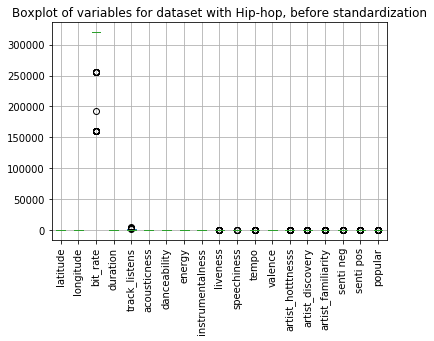

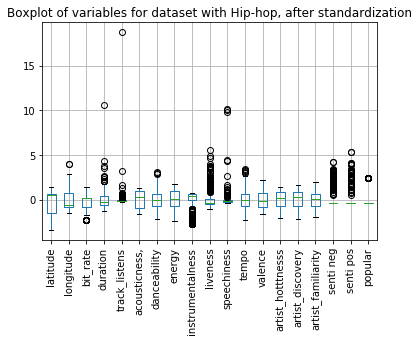

In [12]:
# Make boxplot of variables for hiphop data - before standardization 
Hiphop_10.drop(['track_ID'], axis=1).astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Hip-hop, before standardization')
plt.xticks(rotation=90)
plt.show()

# Make boxplot of variables for hiphop data - after standardization 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Hiphop_10_scaled = scaler.fit_transform(Rock_10.drop(['track_ID'], axis=1))
Hiphop_10_scaled = pd.DataFrame(Hiphop_10_scaled)
Hiphop_10_scaled.rename(columns={0: 'latitude', 1:'longitude',2:'bit_rate',3:'duration',4:'track_listens',5:'acousticness,',6:'danceability',7:'energy',8:'instrumentalness',9:'liveness',10:'speechiness',11:'tempo',12:'valence',13:'artist_hotttnesss',14:'artist_discovery',15:'artist_familiarity',16:'senti neg',17:'senti pos',18:'popular',19:'Rock',20:'Hip-Hop',21:'Electronic'}, inplace=True)

Hiphop_10_scaled.astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Hip-hop, after standardization')
plt.xticks(rotation=90)
plt.show()

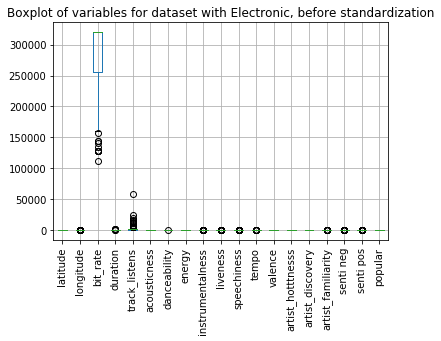

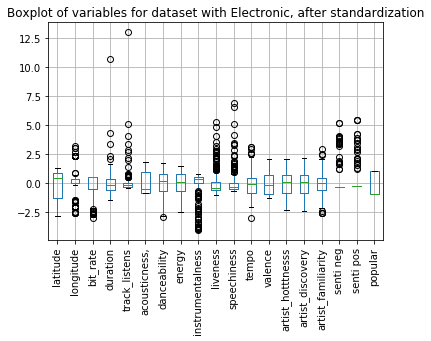

In [13]:
# Make boxplot of variables for electronic data - before standardization 
Elec_10.drop(['track_ID'], axis=1).astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Electronic, before standardization')
plt.xticks(rotation=90)
plt.show()

# Make boxplot of variables for electronic data - after standardization 
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
Elec_10_scaled = scaler.fit_transform(Elec_10.drop(['track_ID'], axis=1))
Elec_10_scaled = pd.DataFrame(Elec_10_scaled)
Elec_10_scaled.rename(columns={0: 'latitude', 1:'longitude',2:'bit_rate',3:'duration',4:'track_listens',5:'acousticness,',6:'danceability',7:'energy',8:'instrumentalness',9:'liveness',10:'speechiness',11:'tempo',12:'valence',13:'artist_hotttnesss',14:'artist_discovery',15:'artist_familiarity',16:'senti neg',17:'senti pos',18:'popular',19:'Rock',20:'Hip-Hop',21:'Electronic'}, inplace=True)

Elec_10_scaled.astype(float).boxplot()
plt.title('Boxplot of variables for dataset with Electronic, after standardization')
plt.xticks(rotation=90)
plt.show()

## Exploratory analysis

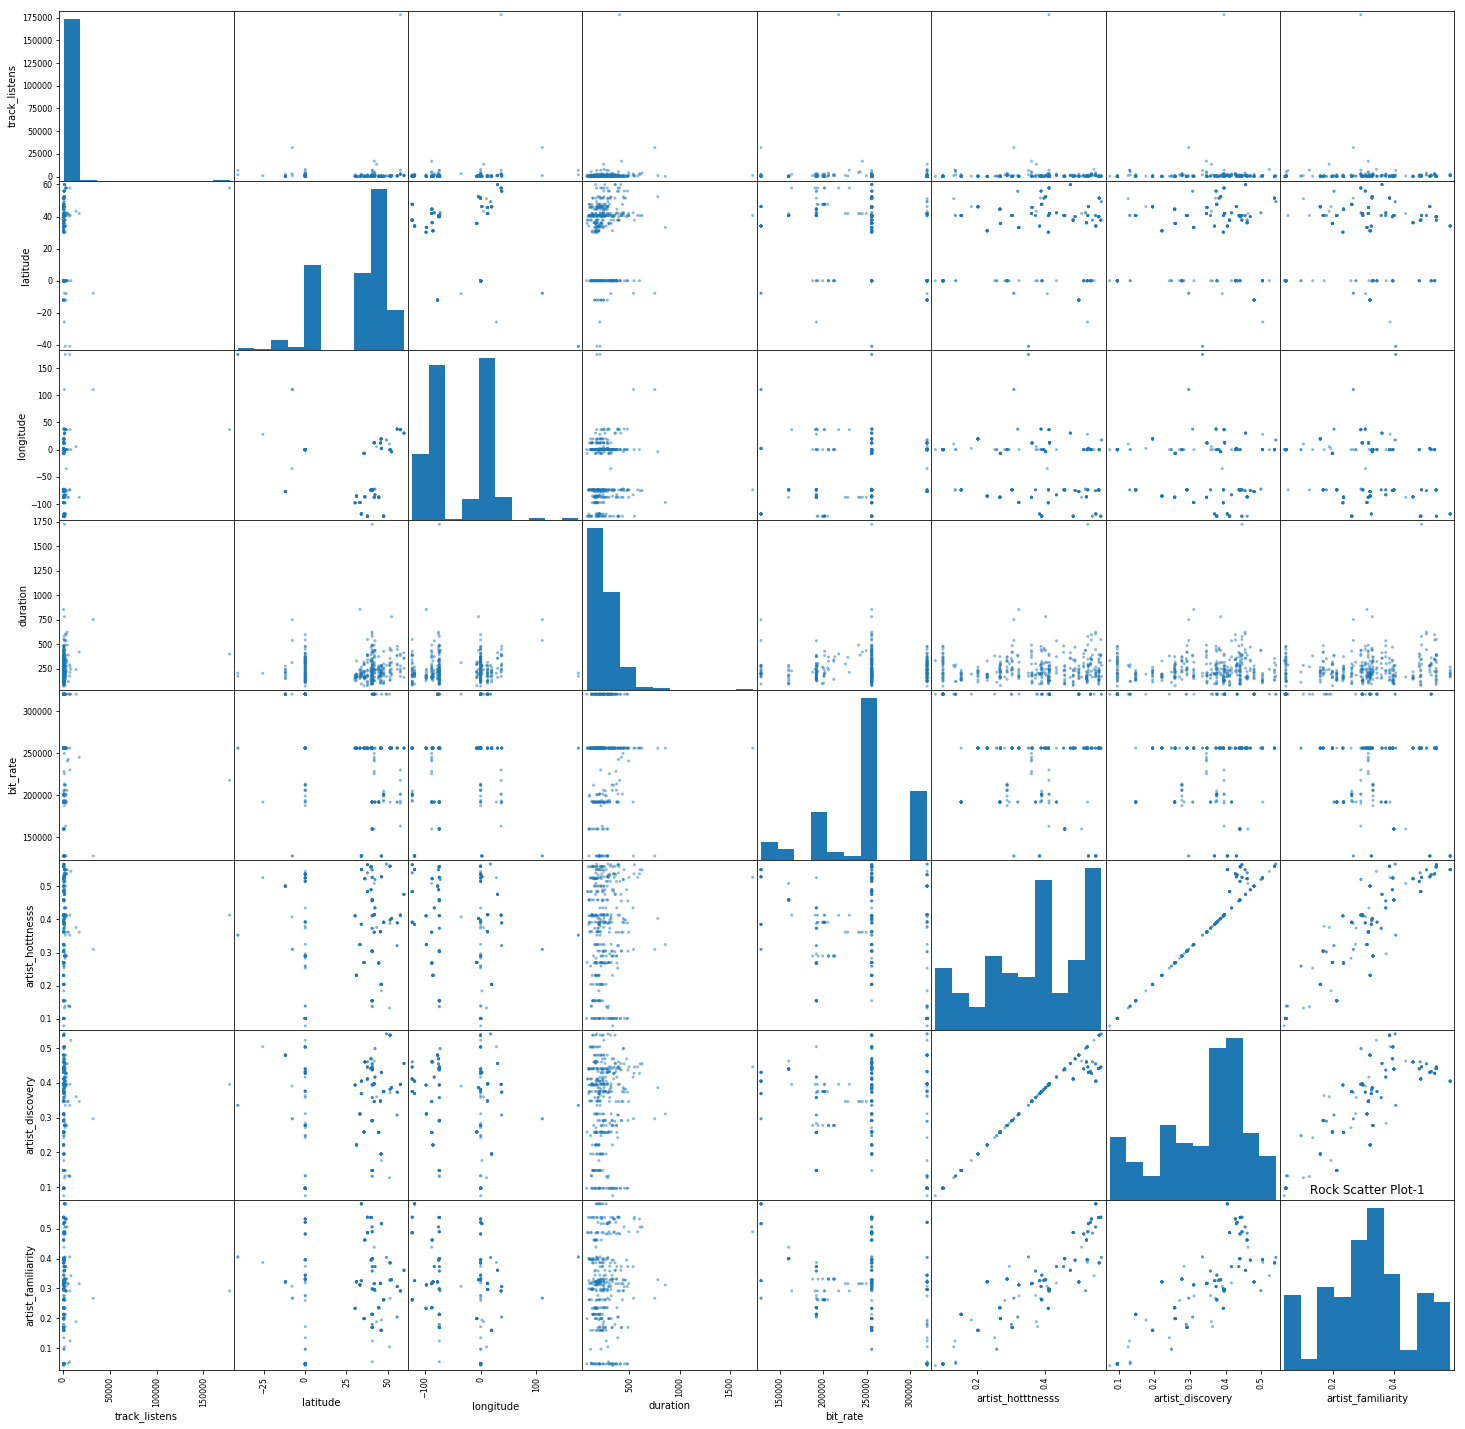

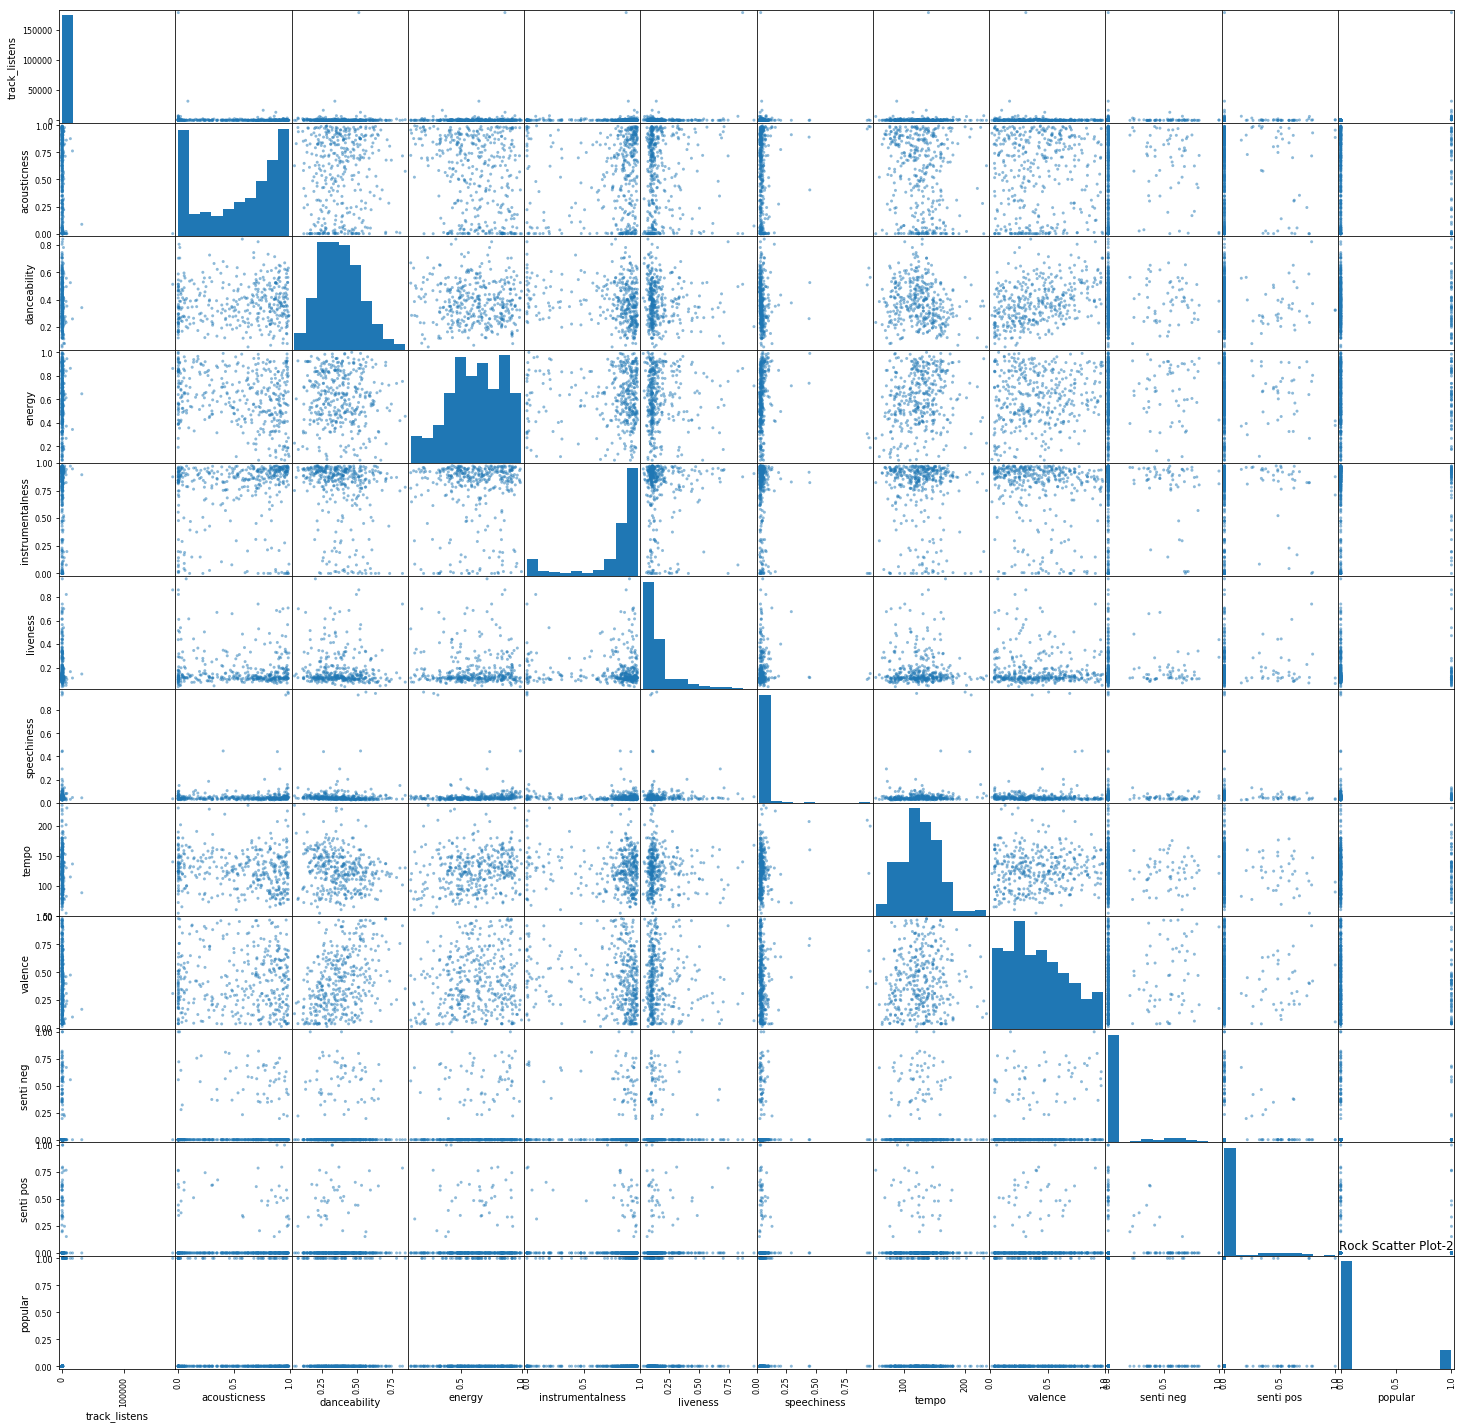

In [14]:
# Make scatter plots of numerical variables versus outcome (track listens)

#Rock
rock10=Rock_10.drop(['track_ID'], axis=1)
rockm=rock10.apply(pd.to_numeric, errors='coerce')
rock102=rockm.drop(['latitude','longitude','duration','bit_rate','artist_hotttnesss','artist_discovery','artist_familiarity'],axis=1)
rock101=rockm[['track_listens','latitude','longitude','duration','bit_rate','artist_hotttnesss','artist_discovery','artist_familiarity']]

# Scatter matrix for echonest data
scatter_matrix(rock101,figsize=(25,25))
plt.title('Rock Scatter Plot-1')
plt.show()

# Scatter matrix for track data
scatter_matrix(rock102,figsize=(25,25))
plt.title('Rock Scatter Plot-2')
plt.show()


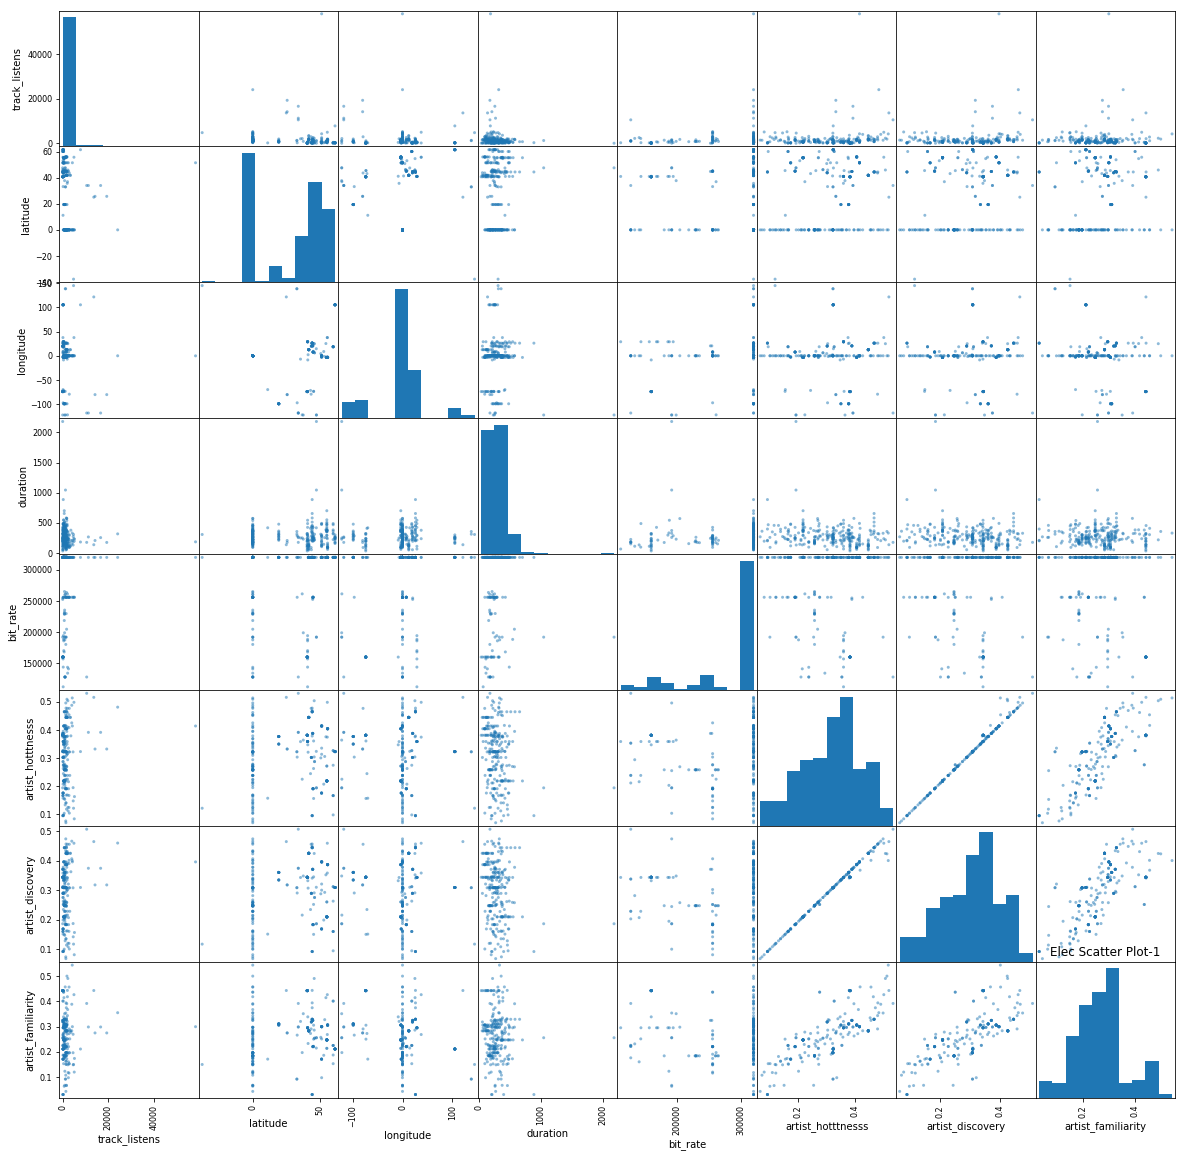

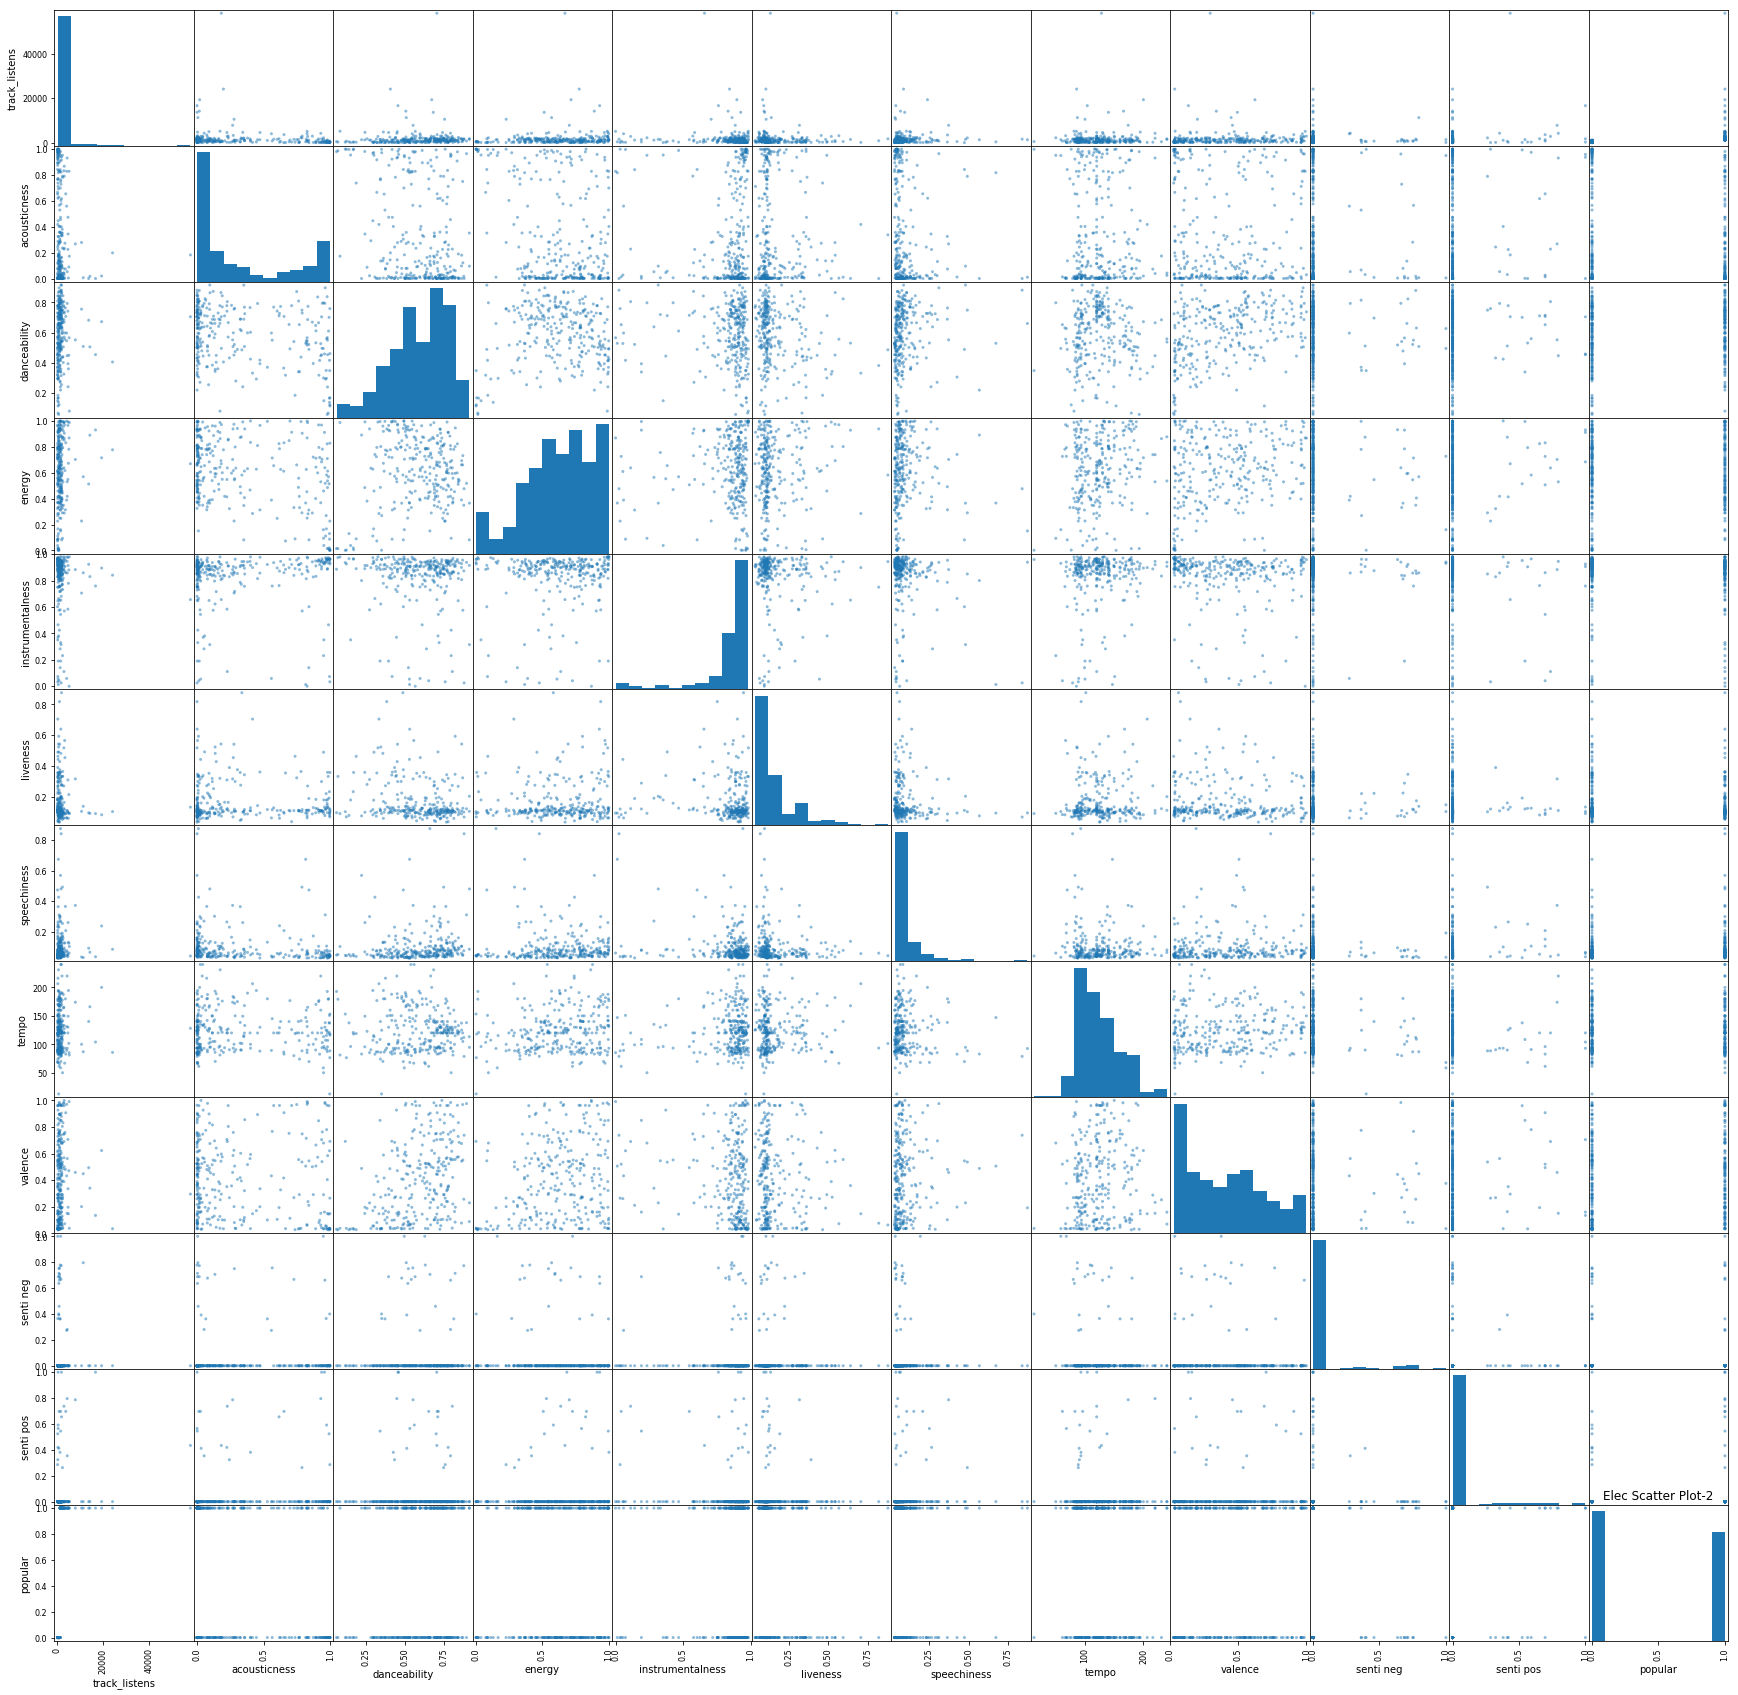

In [15]:
#Electronic
elec10=Elec_10.drop(['track_ID'], axis=1)
elecm=elec10.apply(pd.to_numeric, errors='coerce')
elec102=elecm.drop(['latitude','longitude','duration','bit_rate','artist_hotttnesss','artist_discovery','artist_familiarity'],axis=1)
elec101=elecm[['track_listens','latitude','longitude','duration','bit_rate','artist_hotttnesss','artist_discovery','artist_familiarity']]

scatter_matrix(elec101,figsize=(20,20))
plt.title('Elec Scatter Plot-1')
plt.show()

scatter_matrix(elec102,figsize=(30,30))
plt.title('Elec Scatter Plot-2')
plt.show()

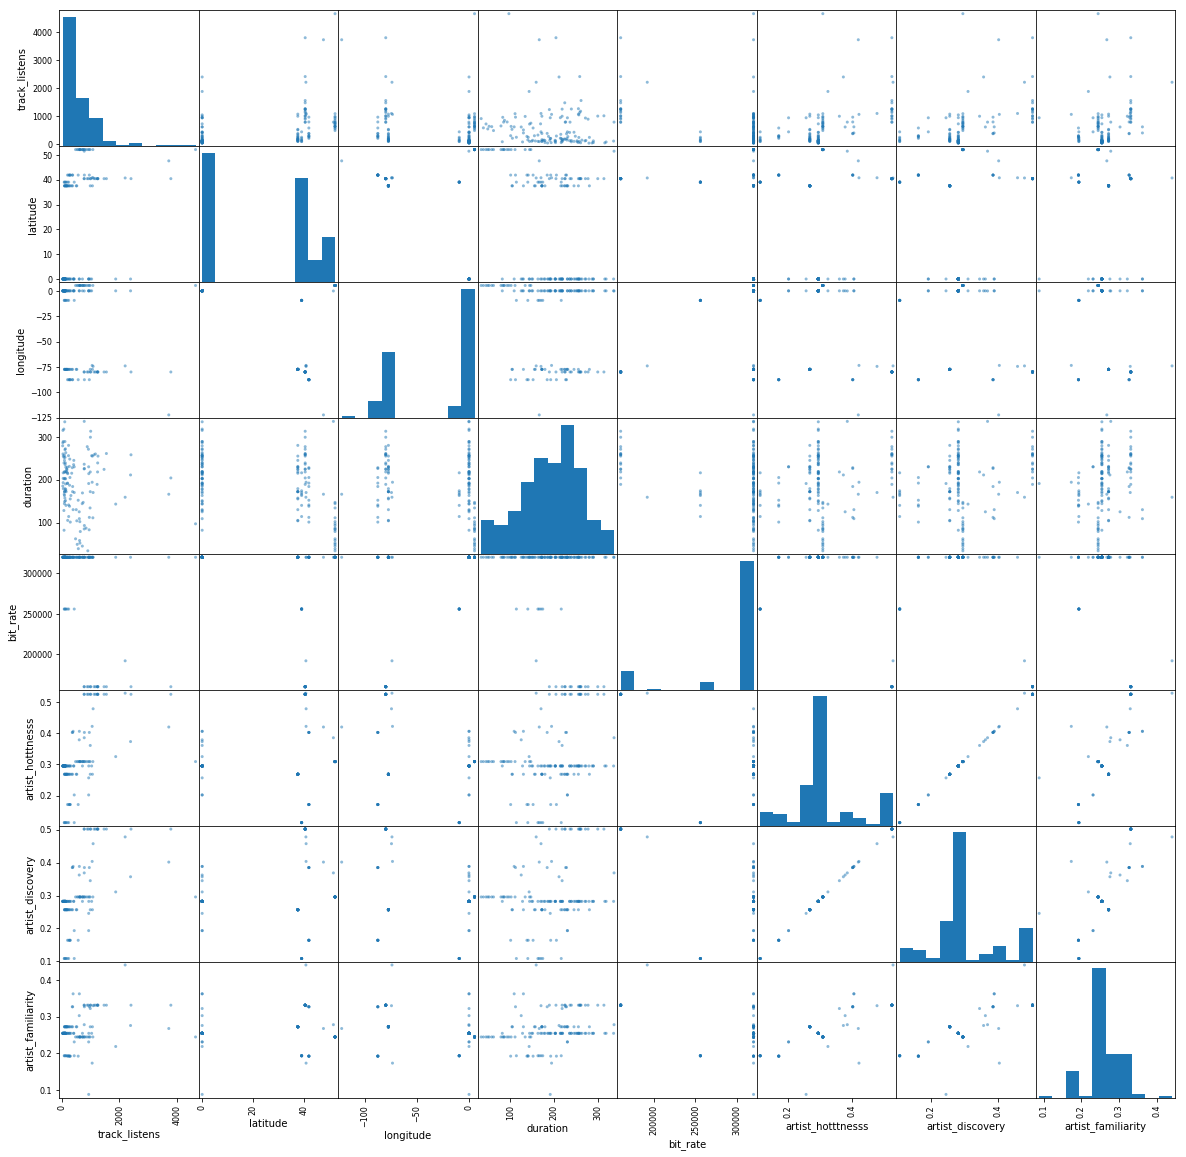

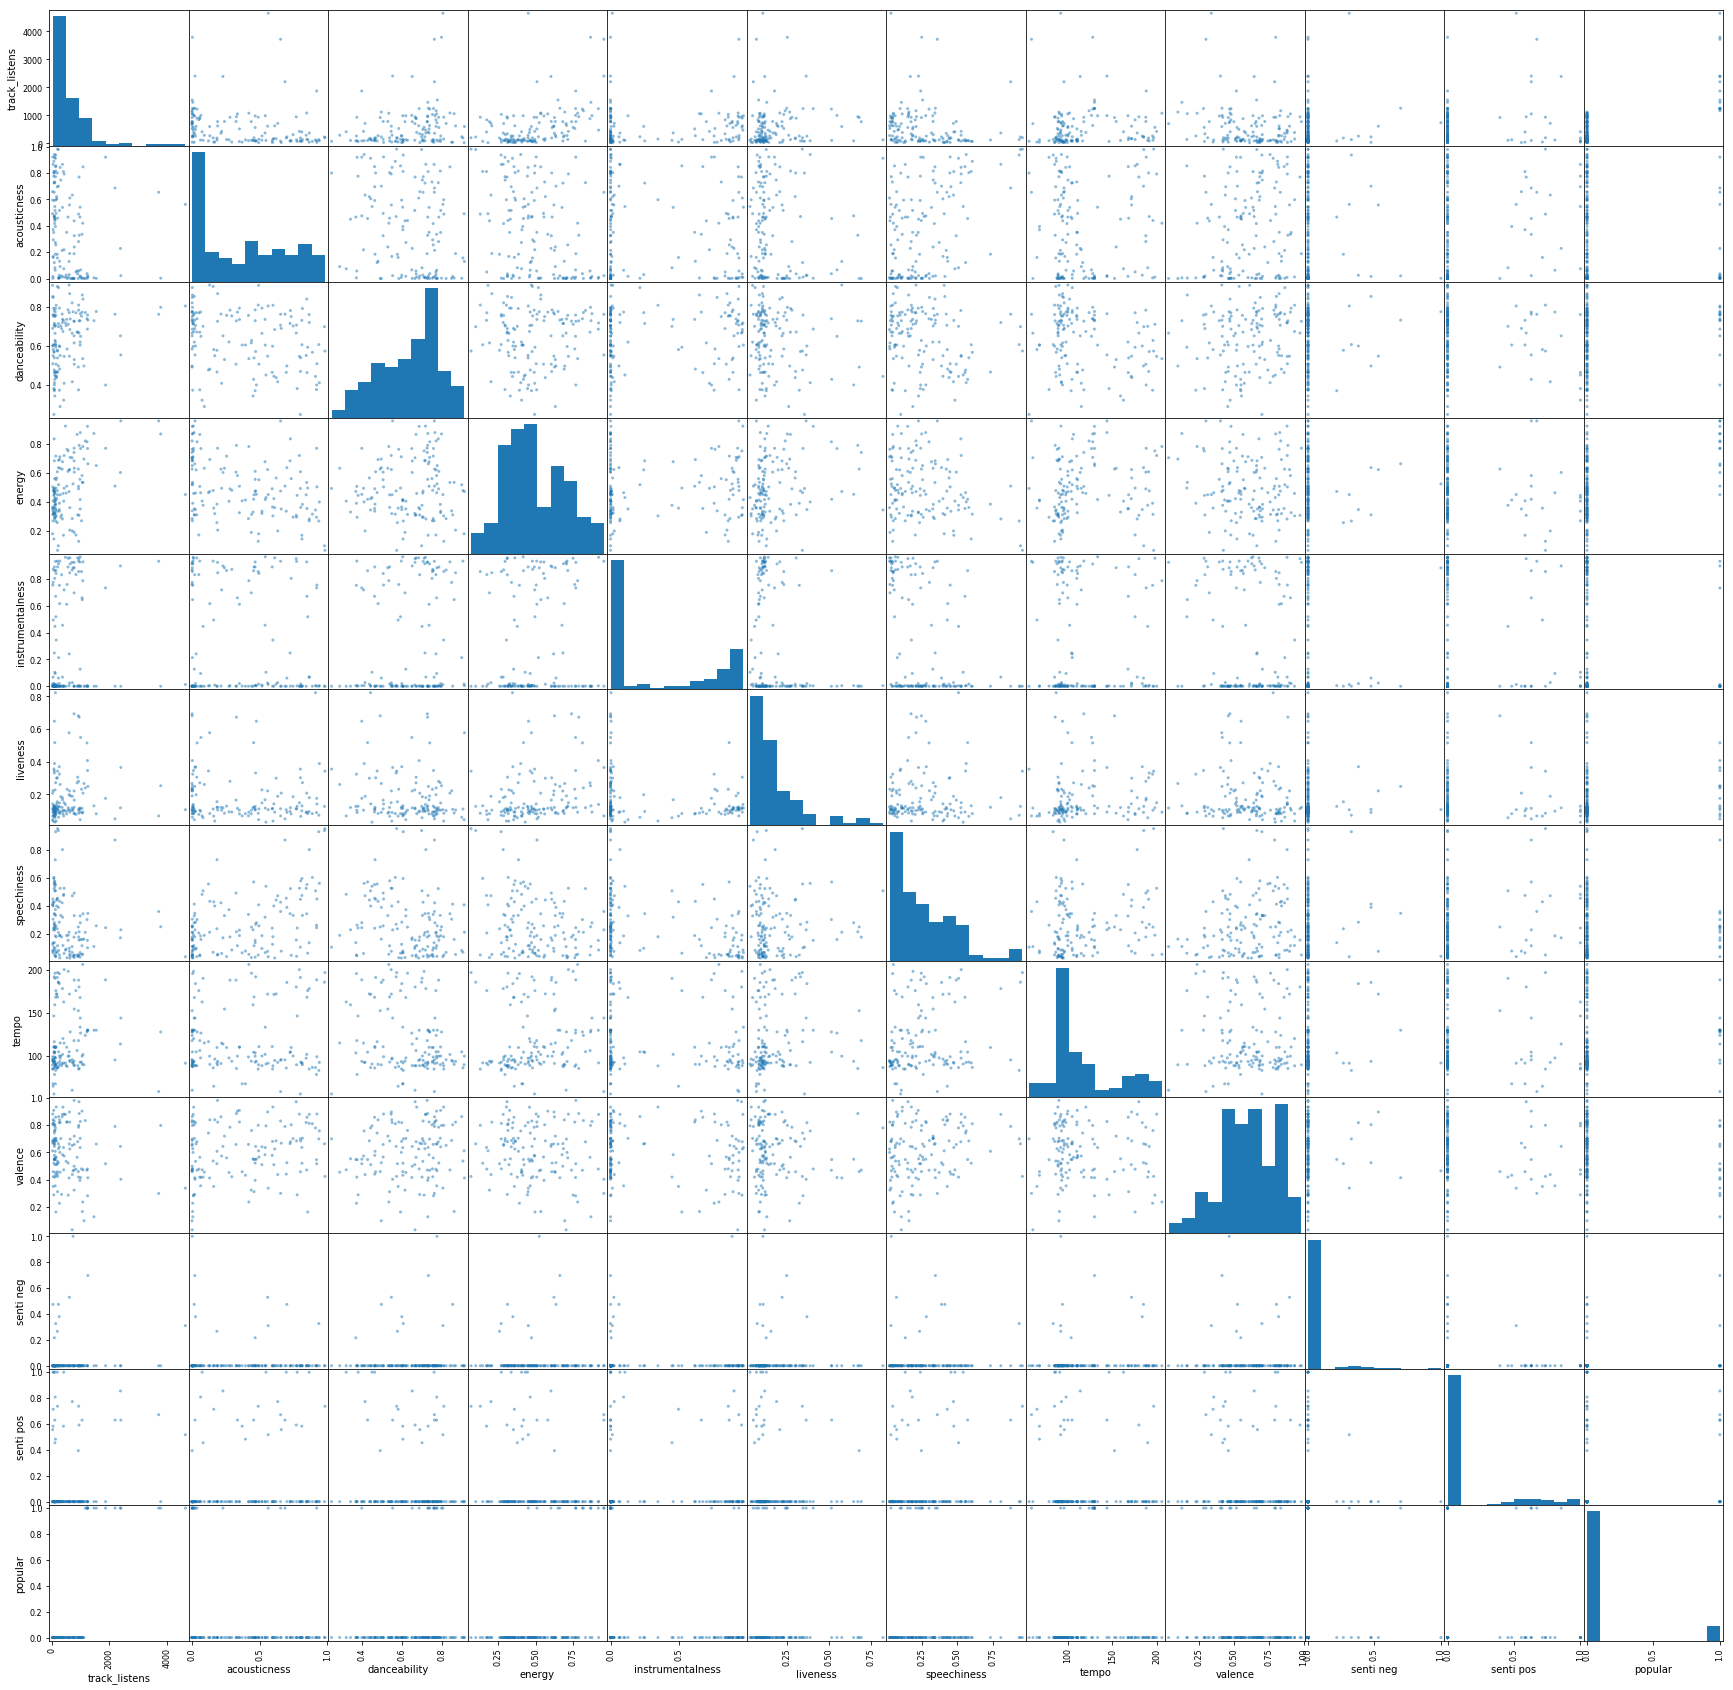

In [16]:
#hip hop
hp=Hiphop_10.drop(['track_ID'], axis=1)
hhm=hp.apply(pd.to_numeric, errors='coerce')
hh102=hhm.drop(['latitude','longitude','duration','bit_rate','artist_hotttnesss','artist_discovery','artist_familiarity'],axis=1)
hh101=hhm[['track_listens','latitude','longitude','duration','bit_rate','artist_hotttnesss','artist_discovery','artist_familiarity']]

scatter_matrix(hh101,figsize=(20,20))
plt.show()

scatter_matrix(hh102,figsize=(30,30))
plt.show()

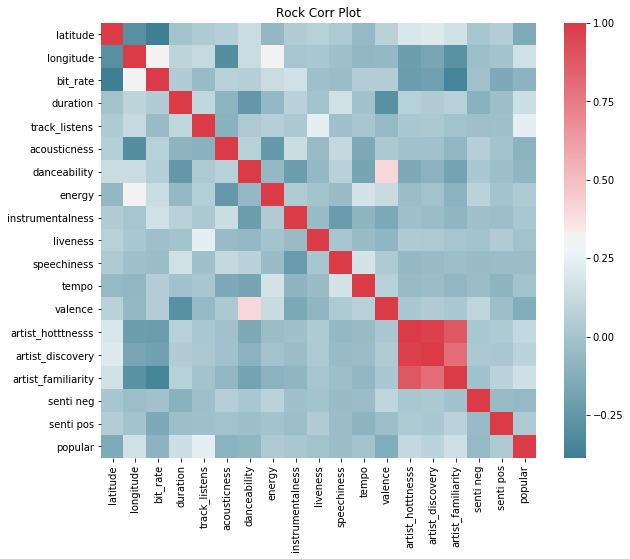

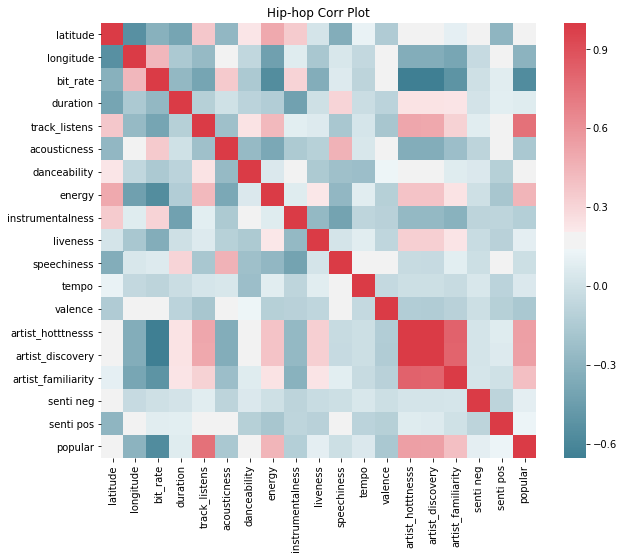

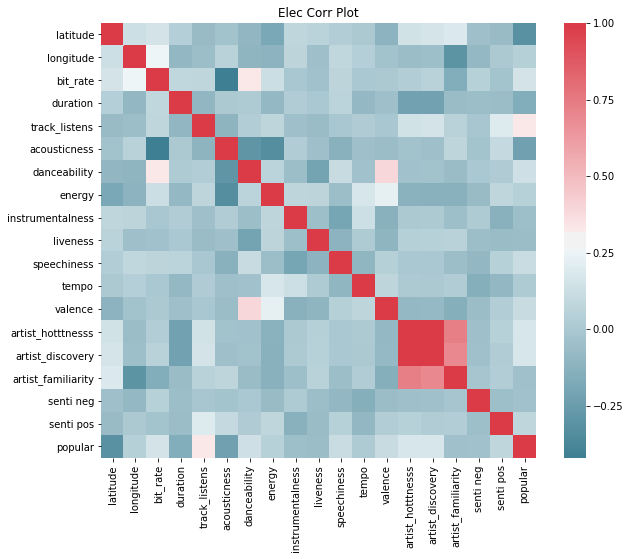

In [17]:
# Correlation plots between varaibles

import seaborn as sns

# Rock
f, ax = plt.subplots(figsize=(10, 8))
corr = rockm.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('Rock Corr Plot')
plt.show()

# Hip hop
f, ax = plt.subplots(figsize=(10, 8))
corr = hhm.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('Hip-hop Corr Plot')
plt.show()

# Electronic
f, ax = plt.subplots(figsize=(10, 8))
corr = elecm.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('Elec Corr Plot')
plt.show()



We see strong correlation between artist hotttness, artist discovery and artist familiarity, which is consistent with intuition - we will select one of these moving forward.

# Model selection

## Baseline Model with logistic regression

In [18]:
# Function for plotting ROC
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Area under the ROC curve : 0.767172


C:\Users\qusac\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


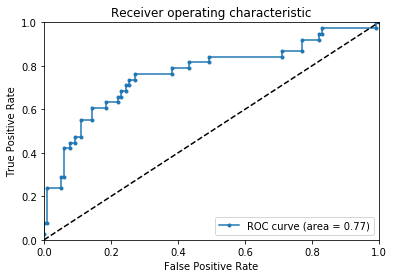

In [19]:
# Train logistic regression on popularity  - include genre as a categorical variable
from sklearn.linear_model import LogisticRegression
y = t10['popular']
X=t10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

regr = LogisticRegression(penalty='l1')
regr.fit(X_train, y_train)

#compute AUC ROC
import sklearn.metrics
from sklearn.metrics import roc_curve, auc

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

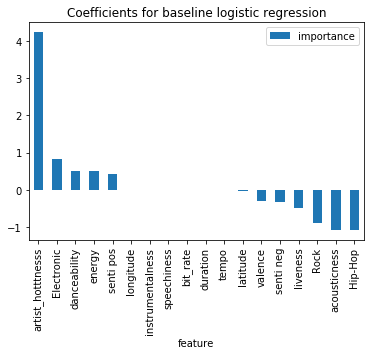

                   importance
feature                      
artist_hotttnesss    4.233013
Electronic           0.819540
danceability         0.508358
energy               0.496399
senti pos            0.414536


In [20]:
# Plot coefficient importance
importances = pd.DataFrame({'feature':t10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.coef_[0]})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Coefficients for baseline logistic regression')
plt.show()
print(importances[:5])

Since the genre variables are important, different genres can be analyzed separately to see what makes these genres distinct.

# Rock Music

In [21]:
# scale the data and split to train - test sets
y = Rock_10[['popular']].values.ravel()
X=Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).astype(float).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

## Logistic Regression - rock 

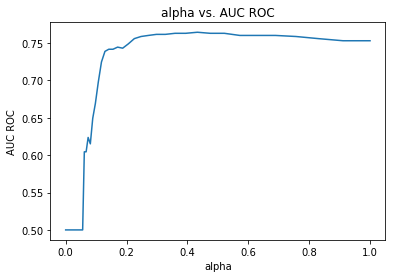

Optimal C value for logistic regression: 0.43287612810830617


In [22]:
# Regularize over L1 penalty 
C_vals = np.logspace(-4,0,100)
scores = []
for C_val in C_vals:
    
    #change penalty to l1
    regr = LogisticRegression(penalty='l1', C = C_val)
    regr.fit(X_train, y_train)
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    scores.append(roc_auc)
    
#plot alphas vs. scores
plt.plot(C_vals, scores)
plt.xlabel('alpha')
plt.ylabel('AUC ROC')
plt.title('alpha vs. AUC ROC')
plt.show()

C_best_L1 = C_vals[scores.index(max(scores))]
print('Optimal C value for logistic regression: ' + str(C_best_L1))

Area under the ROC curve : 0.764205


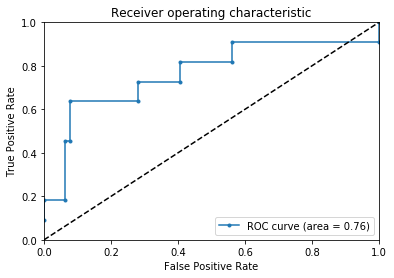

In [23]:
# Train logistic regression for popularity
from sklearn.linear_model import LogisticRegression
regr = LogisticRegression(penalty='l1',C=C_best_L1)
regr.fit(X_train, y_train)

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

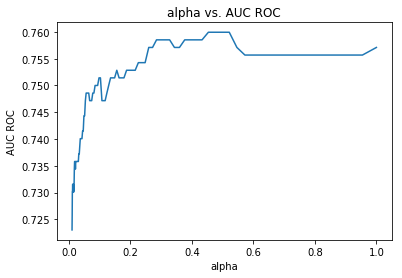

Optimal C value for logistic regression: 0.4534878508128584


In [24]:
# Regularization with L2 penalty instead
C_vals = np.logspace(-2,0,100)
scores = []
for C_val in C_vals:
    
    #change penalty to l2
    regr = LogisticRegression(penalty='l2', C = C_val)
    regr.fit(X_train, y_train)
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    scores.append(roc_auc)
    
#plot alphas vs. scores
plt.plot(C_vals, scores)
plt.xlabel('alpha')
plt.ylabel('AUC ROC')
plt.title('alpha vs. AUC ROC')
plt.show()

C_best = C_vals[scores.index(max(scores))]
print('Optimal C value for logistic regression: ' + str(C_best))

Area under the ROC curve : 0.759943


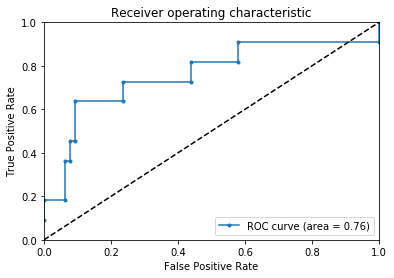

In [25]:
# Train logistic regression for popularity
from sklearn.linear_model import LogisticRegression
regr = LogisticRegression(penalty='l2',C=C_best)
regr.fit(X_train, y_train)

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l2 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

[0.50651042 0.48917749 0.61760462 0.70707071 0.63492063]


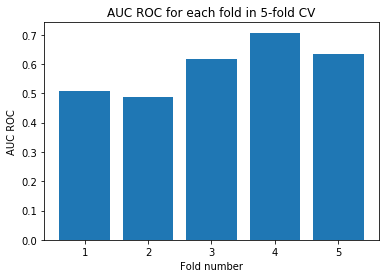

0.5910567730880232


In [26]:
# Choose L1 penalty since we want to have more variables -> 0 - perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = LogisticRegression(C=C_best_L1, penalty='l1')
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

print(np.mean(scores))

[0.75       0.85135135 0.85135135 0.85135135 0.85135135]


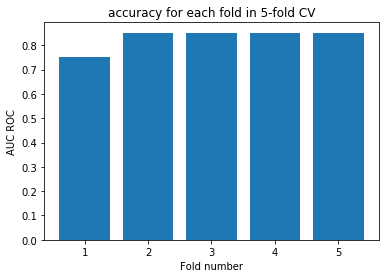

0.831081081081081


In [27]:
# Choose L1 penalty since we want to have more variables -> 0 - perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = LogisticRegression(C=C_best_L1, penalty='l1')
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5)
print(scores)
plt.bar(range(1,6),scores)
plt.title('accuracy for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

print(np.mean(scores))

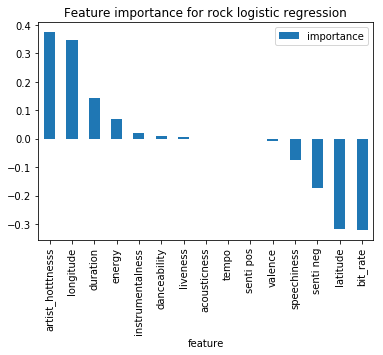

                   importance
feature                      
artist_hotttnesss    0.373916
longitude            0.348576
duration             0.142890
energy               0.069096
instrumentalness     0.019365


In [28]:
# Plot coefficient importance
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.coef_[0]})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for rock logistic regression')
plt.show()
print(importances[:5])

# Decision tree

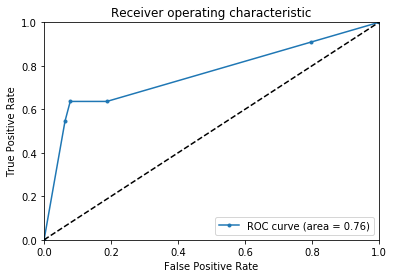

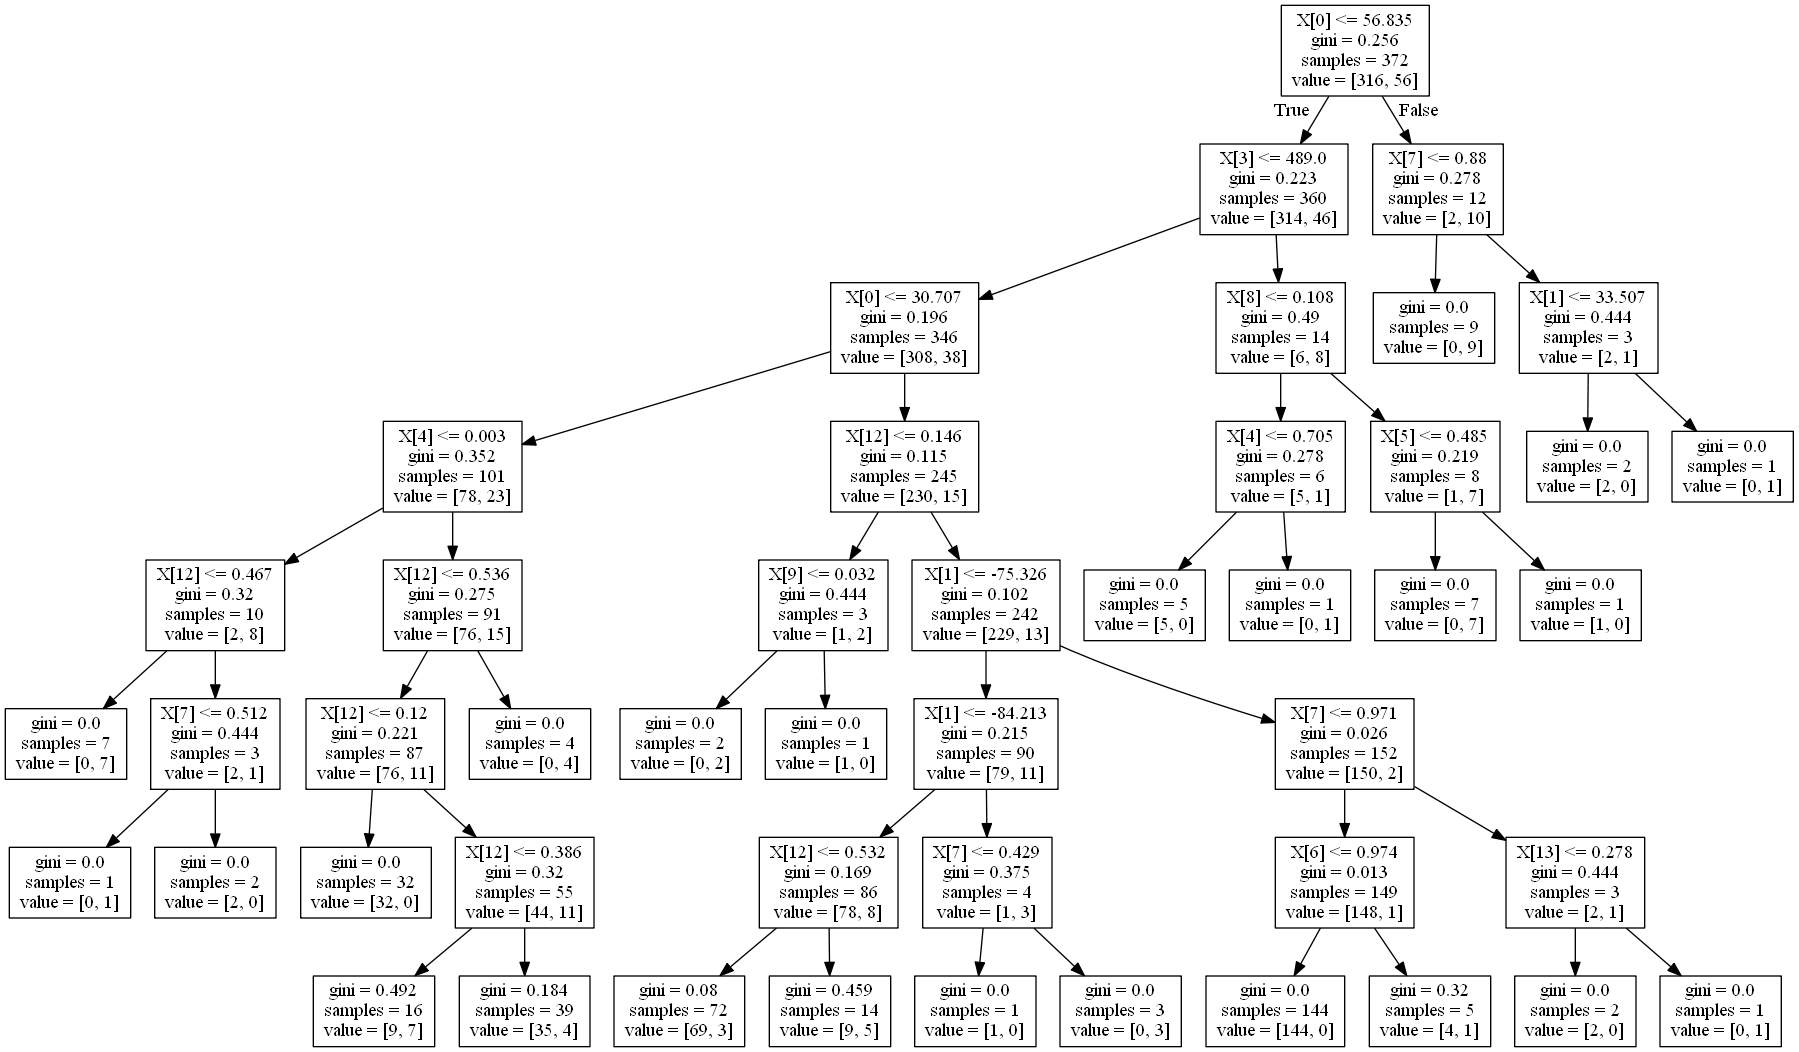

In [29]:
#Visualize the decision tree
# Import the necessary modules and libraries
import os
import subprocess
import pandas as pd
from PIL import Image, ImageFilter
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from sklearn.utils import shuffle
from IPython.display import Image

random_state = np.random.RandomState(0)
regr_7 = DecisionTreeClassifier(max_depth=7)
dt = regr_7.fit(X_train, y_train)

probas_ = regr_7.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)

#Visualize
pydotplus.find_graphviz()
regr = DecisionTreeClassifier(max_depth=7)
regr = regr.fit(X, y)
dot_file = open('dt.dot','w')
export_graphviz(regr, out_file='dt.dot')

os.system("dot -Tpng dt.dot -o dtree.png")
im = Image('dtree.png')
im.format = "png"
display(im)

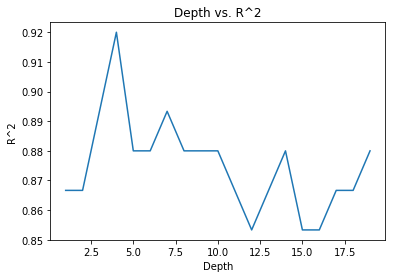

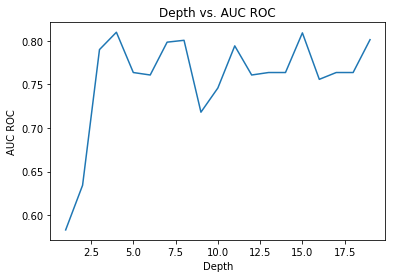

Optimal depth: 4


In [30]:
#check for different tree depths 
train_errors=[]
test_errors=[]
scores=[]
auc_rocs = []

depths = range(1,20)
for n in depths:
    regr = DecisionTreeClassifier(max_depth=n)
    
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    auc_rocs.append(roc_auc)
    
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.title('Depth vs. R^2')
plt.plot(depths,scores)
plt.show()

plt.ylabel('AUC ROC')
plt.xlabel('Depth')
plt.title('Depth vs. AUC ROC')
plt.plot(depths,auc_rocs)
plt.show()

test_errors=scores
n_opt=depths[np.argmax(auc_rocs)]

print('Optimal depth: ' + str(n_opt))

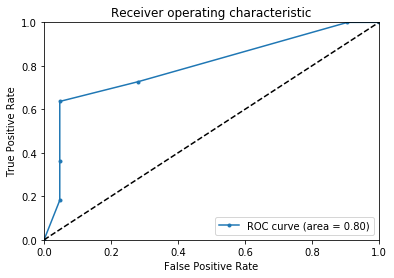

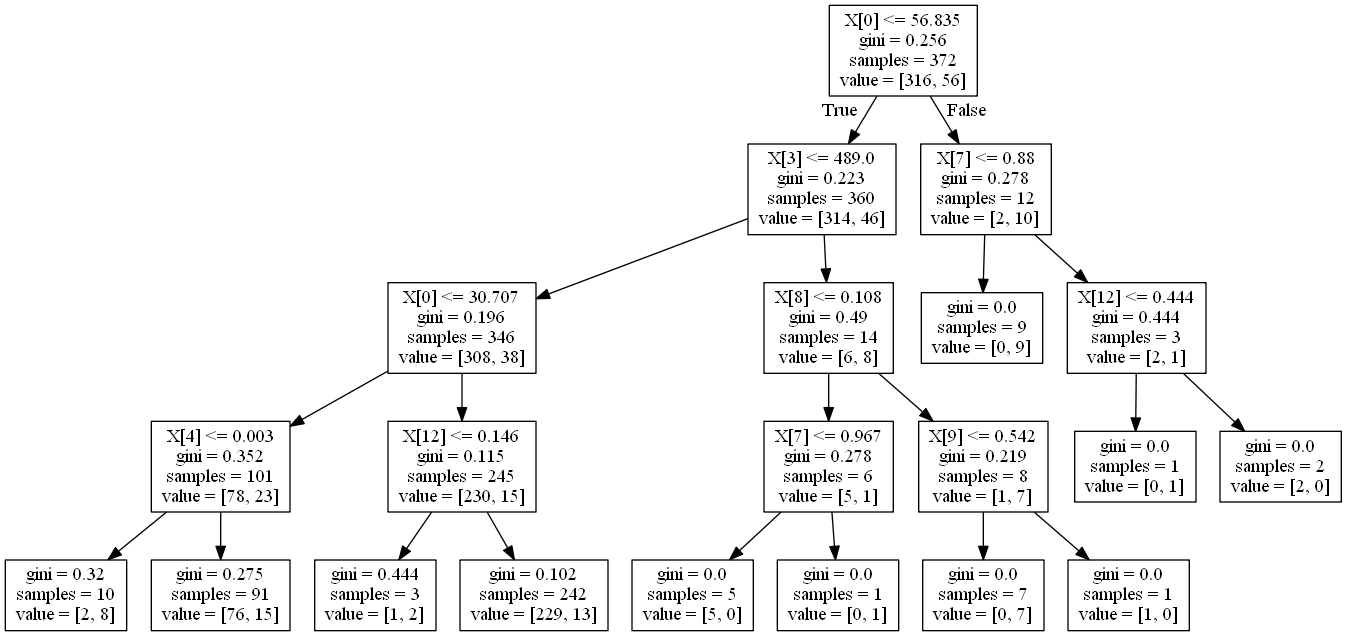

In [31]:
# Fit decision tree classifier with optimal depth
regr_opt = DecisionTreeClassifier(max_depth=n_opt)
regr_opt.fit(X_train, y_train)

probas_ = regr_opt.fit(X_train, y_train).predict_proba(X_test)
    
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)

# Visualize
pydotplus.find_graphviz()
regr = DecisionTreeClassifier(max_depth=n_opt)
regr = regr.fit(X, y)
dot_file = open('dt.dot','w')
export_graphviz(regr, out_file='dt.dot')

os.system("dot -Tpng dt.dot -o dtree.png")
im = Image('dtree.png')
im.format = "png"
display(im)

[0.52148438 0.47979798 0.47330447 0.56349206 0.46320346]


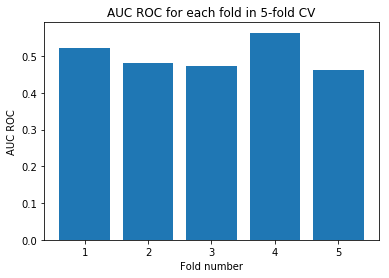

0.5002564709595959


In [32]:
# test on random folds - cross validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = DecisionTreeClassifier(max_depth=n_opt)
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

print(np.mean(scores))

[0.72368421 0.77027027 0.85135135 0.86486486 0.87837838]


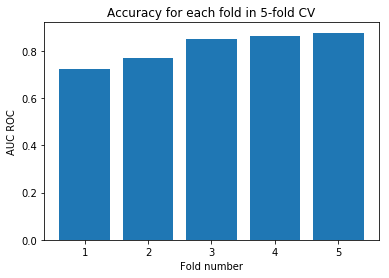

0.8177098150782361


In [33]:
# cross validation on accuracy
from sklearn.model_selection import cross_val_score

# cross validation
regr = DecisionTreeClassifier(max_depth=n_opt)
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5)
print(scores)
plt.bar(range(1,6),scores)
plt.title('Accuracy for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

print(np.mean(scores))

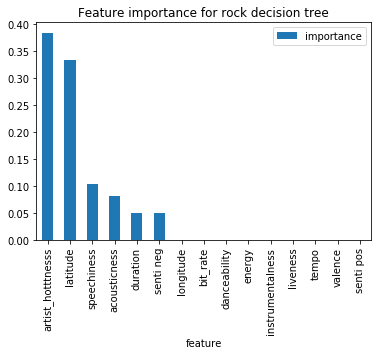

                   importance
feature                      
artist_hotttnesss    0.383284
latitude             0.333333
speechiness          0.103438
acousticness         0.081312
duration             0.049668


In [34]:
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for rock decision tree')
plt.show()
print(importances[:5])

# Random forest

89.33333333333333


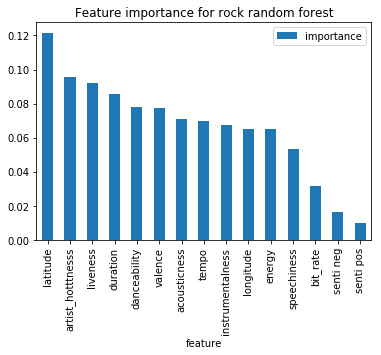

                   importance
feature                      
latitude             0.121526
artist_hotttnesss    0.095802
liveness             0.092306
duration             0.085551
danceability         0.078048


In [35]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_test, y_test)
acc_random_forest = random_forest.score(X_test, y_test) * 100
print(acc_random_forest)
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':random_forest.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for rock random forest')
plt.show()
print(importances[:5])

In [36]:
# Check for different tree depths and number of features 
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier()
param_grid = { 'max_depth' : np.arange(1,10), 'max_features' : np.arange(1,10)}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'max_depth': 8, 'max_features': 7}

Area under the ROC curve : 0.941761


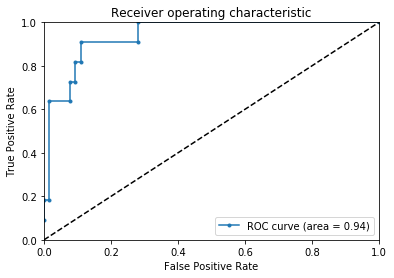

In [37]:
#roc auc for random forest
random_forest = RandomForestClassifier(n_estimators=100,max_depth=CV_rfc.best_params_['max_depth'],max_features=CV_rfc.best_params_['max_features'])
random_forest.fit(X_train, y_train)

#compute ROC 
probas_ = random_forest.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

In [38]:
#Cross Validation
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100,max_depth=CV_rfc.best_params_['max_depth'],max_features=CV_rfc.best_params_['max_features'])
scores = cross_val_score(rf, X_scaled, y, cv=5, scoring = "roc_auc")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.58333333 0.44155844 0.6046176  0.66810967 0.49206349]
Mean: 0.557936507936508
Standard Deviation: 0.0810498085182584


[0.60546875 0.39249639 0.54545455 0.65223665 0.52669553]


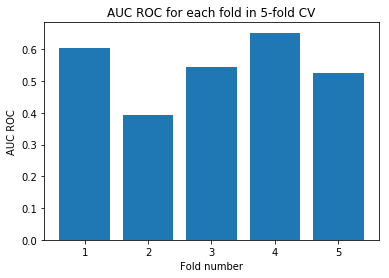

Mean: 0.5444703733766234


In [39]:
# cross validation
rf.fit(X_train, y_train)

scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()
print("Mean:", scores.mean())

[0.82894737 0.85135135 0.78378378 0.83783784 0.83783784]


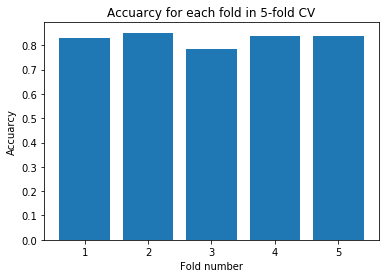

Mean: 0.8279516358463728


In [40]:
# cross validation on accuracy
rf.fit(X_train, y_train)

scores = cross_val_score(rf, X_scaled, y, cv=5)
print(scores)
plt.bar(range(1,6),scores)
plt.title('Accuarcy for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('Accuarcy')
plt.show()
print("Mean:", scores.mean())

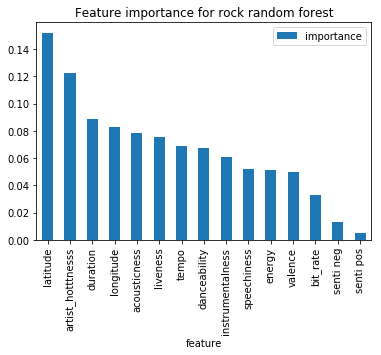

                   importance
feature                      
latitude             0.151802
artist_hotttnesss    0.122077
duration             0.088530
longitude            0.082488
acousticness         0.078167


In [41]:
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':rf.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for rock random forest')
plt.show()
print(importances[:5])

# kNeighborsClassifier

In [42]:
#Reset Data
y = Rock_10[['popular']].values.ravel()
X=Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).astype(float).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

In [43]:
#Run grid search for best parameters
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = { 'n_neighbors' : np.arange(1,10)}
CV_rfc = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'n_neighbors': 6}

In [44]:
# run knn classifier
knn = KNeighborsClassifier(n_neighbors=CV_rfc.best_params_['n_neighbors'])
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)

acc_knn = knn.score(X_test, y_test) * 100
print(acc_knn)

86.66666666666667


Area under the ROC curve : 0.905540


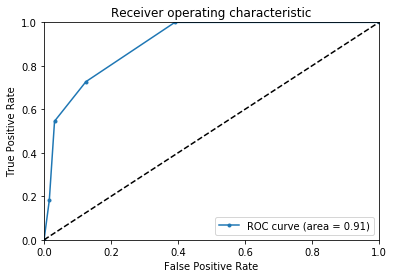

In [45]:
#roc auc for knn
knn = KNeighborsClassifier(n_neighbors=CV_rfc.best_params_['n_neighbors'])
knn.fit(X_train, y_train)

#compute ROC 
probas_ = knn.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

In [46]:
#Cross Validation

knn = KNeighborsClassifier(n_neighbors = CV_rfc.best_params_['n_neighbors'])
scores = cross_val_score(knn, X_scaled, y, cv=5, scoring = "roc_auc")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.63997396 0.47907648 0.57431457 0.62337662 0.67604618]
Mean: 0.5985575622294373
Standard Deviation: 0.06811643065831702


[0.63997396 0.47907648 0.57431457 0.62337662 0.67604618]


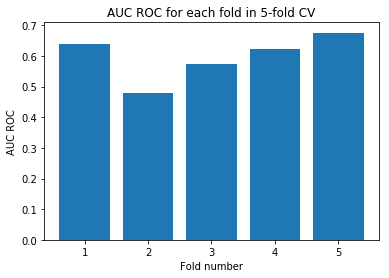

Mean: 0.5985575622294373


In [47]:
scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()
print("Mean:", scores.mean())

[0.81578947 0.86486486 0.85135135 0.85135135 0.85135135]


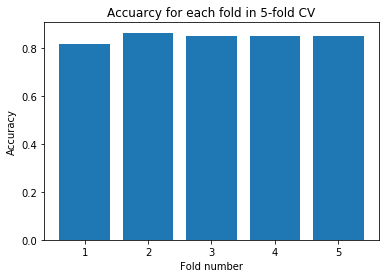

Mean: 0.846941678520626


In [48]:
scores = cross_val_score(knn, X_scaled, y, cv=5)
print(scores)
plt.bar(range(1,6),scores)
plt.title('Accuarcy for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('Accuracy')
plt.show()
print("Mean:", scores.mean())

For rock, across logistic regression, decision tree, and random forest models, we see that latitude, artist hottness, and duration are among the most important features. This tells us that for rock music, the length of the song and the perceived popularity of the artist, as well as some aspect of their location (latitude is north/south direction) are strong indicators of a song's popularity. In addition, we see that our random forest model performs the best on random subsets of data, so we choose our random forest model with a max depth of 7 and max features of 9.

# Hiphop music

In [49]:
# scale the data and split to train - test sets
y = Hiphop_10[['popular']].values.ravel()
X=Hiphop_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).astype(float).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

# Logistic regression

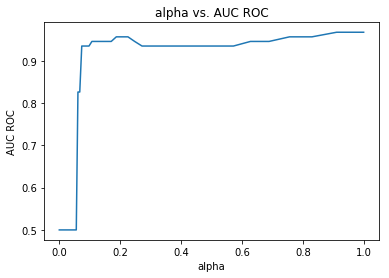

Optimal C value for logistic regression: 0.4534878508128584


In [50]:
# L1 penalty
C_vals = np.logspace(-4,0,100)
scores = []
for C_val in C_vals:
    
    #change penalty to l1
    regr = LogisticRegression(penalty='l1', C = C_val)
    regr.fit(X_train, y_train)
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    scores.append(roc_auc)
    
#plot alphas vs. scores
plt.plot(C_vals, scores)
plt.xlabel('alpha')
plt.ylabel('AUC ROC')
plt.title('alpha vs. AUC ROC')
plt.show()

C_best_L1 = C_vals[scores.index(max(scores))]
print('Optimal C value for logistic regression: ' + str(C_best))

Area under the ROC curve : 0.967391


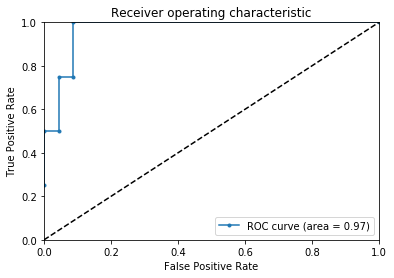

In [51]:
# Train logistic regression for popularity
from sklearn.linear_model import LogisticRegression
regr = LogisticRegression(penalty='l1',C=C_best_L1)
regr.fit(X_train, y_train)

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

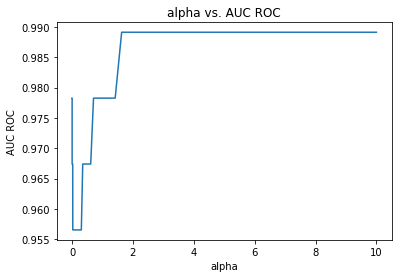

Optimal C value for logistic regression: 1.6297508346206435


In [52]:
# L2 penalty
C_vals = np.logspace(-5,1,100)
scores = []
for C_val in C_vals:
    
    #change penalty to l2
    regr = LogisticRegression(penalty='l2', C = C_val)
    regr.fit(X_train, y_train)
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    scores.append(roc_auc)
    
#plot alphas vs. scores
plt.plot(C_vals, scores)
plt.xlabel('alpha')
plt.ylabel('AUC ROC')
plt.title('alpha vs. AUC ROC')
plt.show()

C_best = C_vals[scores.index(max(scores))]
print('Optimal C value for logistic regression: ' + str(C_best))

Area under the ROC curve : 0.989130


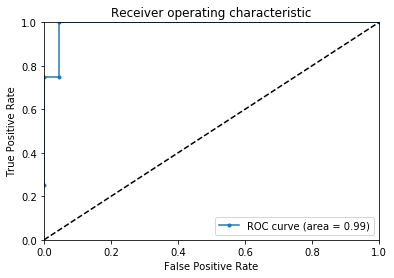

In [53]:
# Train logistic regression for popularity
from sklearn.linear_model import LogisticRegression
regr = LogisticRegression(penalty='l2',C=C_best)
regr.fit(X_train, y_train)

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l2 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

[0.79166667 0.90277778 0.98611111 0.95833333 0.91304348]
0.9103864734299517


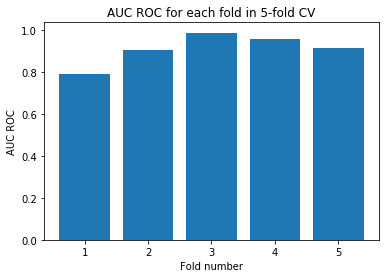

0.9103864734299517


In [54]:
# Choose L1 penalty since we want to have more variables -> 0 - perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = LogisticRegression(C=C_best_L1, penalty='l1')
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
print(np.mean(scores))
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()
print(scores.mean())

[0.88888889 0.92592593 0.96296296 0.88888889 0.68      ]
0.8693333333333333


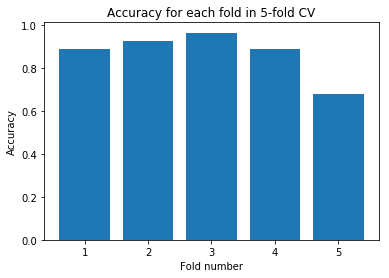

0.8693333333333333


In [55]:
# Choose L1 penalty since we want to have more variables -> 0 - perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = LogisticRegression(C=C_best_L1, penalty='l1')
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5)
print(scores)
print(np.mean(scores))
plt.bar(range(1,6),scores)
plt.title('Accuracy for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('Accuracy')
plt.show()
print(scores.mean())

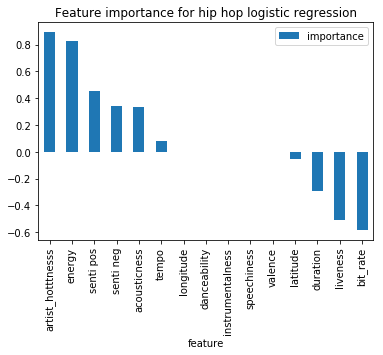

                   importance
feature                      
artist_hotttnesss    0.891222
energy               0.824255
senti pos            0.452785
senti neg            0.341371
acousticness         0.332133


In [56]:
# Plot coefficient importance
importances = pd.DataFrame({'feature':Hiphop_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.coef_[0]})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for hip hop logistic regression')
plt.show()
print(importances[:5])

# Decision tree

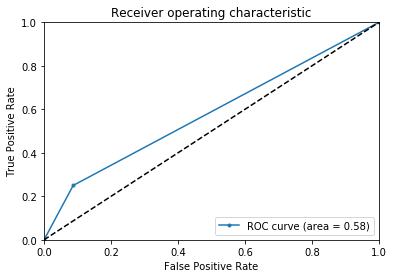

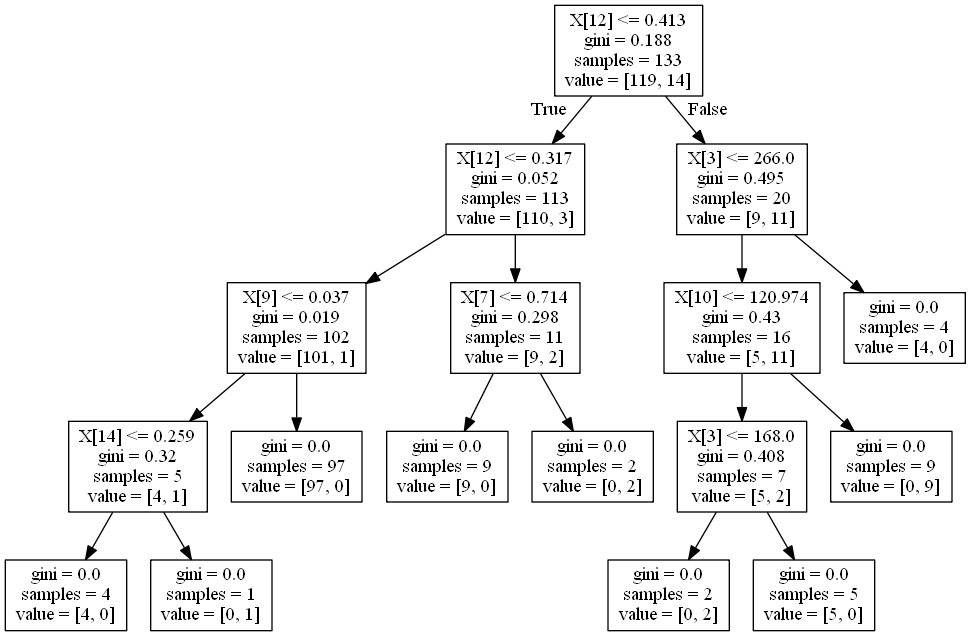

In [57]:
#Visualize the decision tree
# Import the necessary modules and libraries
import os
import subprocess
import pandas as pd
from PIL import Image, ImageFilter
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from sklearn.utils import shuffle
from IPython.display import Image

random_state = np.random.RandomState(0)
regr_7 = DecisionTreeClassifier(max_depth=7)
dt = regr_7.fit(X_train, y_train)

probas_ = regr_7.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)

#Visualize
pydotplus.find_graphviz()
regr = DecisionTreeClassifier(max_depth=7)
regr = regr.fit(X, y)
dot_file = open('dt.dot','w')
export_graphviz(regr, out_file='dt.dot')

os.system("dot -Tpng dt.dot -o dtree.png")
im = Image('dtree.png')
im.format = "png"
display(im)

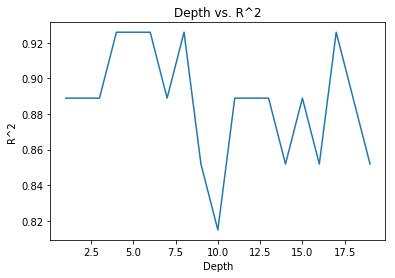

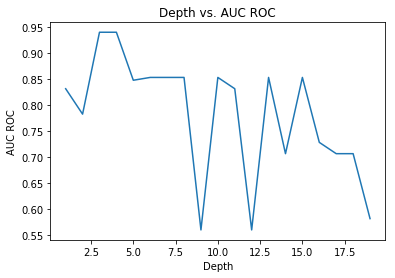

Optimal depth: 3


In [58]:
#check for different tree depths 
train_errors=[]
test_errors=[]
scores=[]
auc_rocs = []

depths = range(1,20)
for n in depths:
    regr = DecisionTreeClassifier(max_depth=n)
    
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    auc_rocs.append(roc_auc)
    
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.title('Depth vs. R^2')
plt.plot(depths,scores)
plt.show()

plt.ylabel('AUC ROC')
plt.xlabel('Depth')
plt.title('Depth vs. AUC ROC')
plt.plot(depths,auc_rocs)
plt.show()

test_errors=scores
n_opt=depths[np.argmax(auc_rocs)]

print('Optimal depth: ' + str(n_opt))

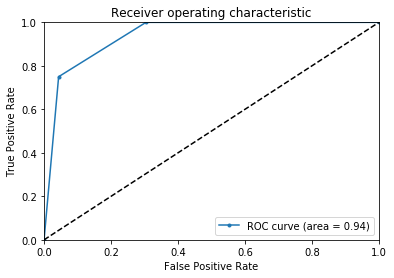

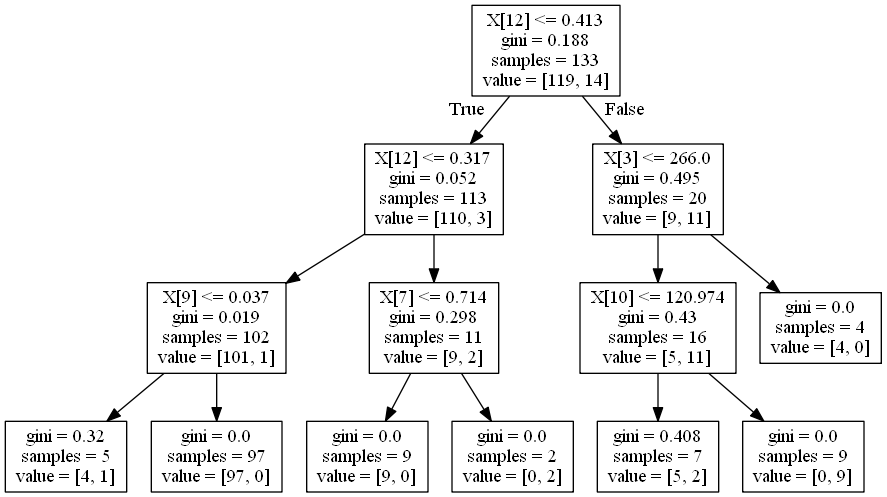

In [59]:
# Fit decision tree classifier with optimal depth
regr_opt = DecisionTreeClassifier(max_depth=n_opt)
regr_opt.fit(X_train, y_train)

probas_ = regr_opt.fit(X_train, y_train).predict_proba(X_test)
    
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)

# Visualize
pydotplus.find_graphviz()
regr = DecisionTreeClassifier(max_depth=n_opt)
regr = regr.fit(X, y)
dot_file = open('dt.dot','w')
export_graphviz(regr, out_file='dt.dot')

os.system("dot -Tpng dt.dot -o dtree.png")
im = Image('dtree.png')
im.format = "png"
display(im)

[0.29166667 0.66666667 0.625      0.9375     0.82608696]


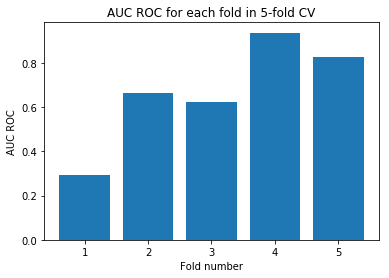

0.6693840579710144


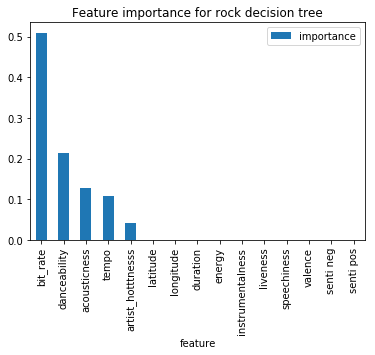

                   importance
feature                      
bit_rate             0.509695
danceability         0.214407
acousticness         0.127069
tempo                0.107203
artist_hotttnesss    0.041626


In [60]:
# test on random folds - cross validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = DecisionTreeClassifier(max_depth=n_opt)
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

print(np.mean(scores))

importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for rock decision tree')
plt.show()
print(importances[:5])

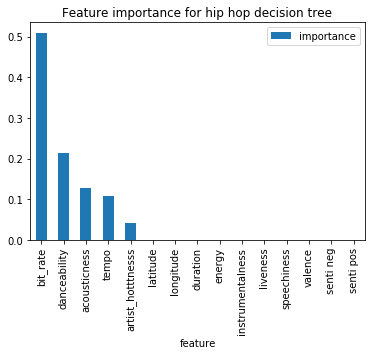

                   importance
feature                      
bit_rate             0.509695
danceability         0.214407
acousticness         0.127069
tempo                0.107203
artist_hotttnesss    0.041626


In [61]:
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for hip hop decision tree')
plt.show()
print(importances[:5])

# Random Forest

92.5925925925926


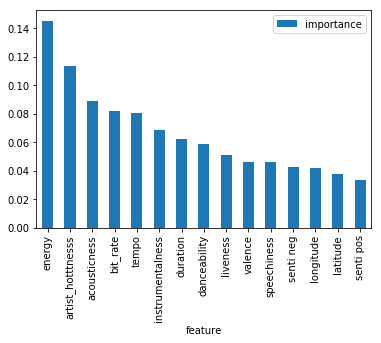

                   importance
feature                      
energy               0.145281
artist_hotttnesss    0.113362
acousticness         0.088933
bit_rate             0.081875
tempo                0.080927


In [62]:
# random forest for hip hop - baseline
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_test, y_test)
acc_random_forest = random_forest.score(X_test, y_test) * 100
print(acc_random_forest)
importances = pd.DataFrame({'feature':Hiphop_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':random_forest.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.show()
print(importances[:5])

In [63]:
#check for different tree depths - regularize
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier()
param_grid = { 'max_depth' : np.arange(1,10), 'max_features' : np.arange(1,10)}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'max_depth': 9, 'max_features': 1}

Area under the ROC curve : 0.978261


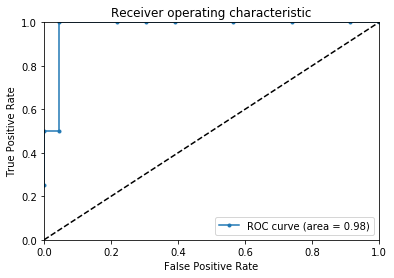

In [64]:
#roc auc for random forest
random_forest = RandomForestClassifier(n_estimators=100,max_depth=CV_rfc.best_params_['max_depth'],max_features=CV_rfc.best_params_['max_features'])
random_forest.fit(X_train, y_train)

#compute ROC 
probas_ = random_forest.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

In [65]:
#Cross Validation
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100,max_depth=CV_rfc.best_params_['max_depth'],max_features=CV_rfc.best_params_['max_features'])
scores = cross_val_score(rf, X_scaled, y, cv=5, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.88888889 0.92592593 0.88888889 0.92592593 0.72      ]
Mean: 0.8699259259259259
Standard Deviation: 0.07677105078532616


[0.57638889 0.95138889 1.         1.         0.95652174]


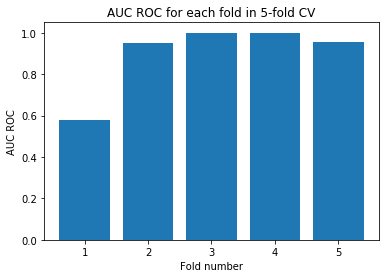

In [66]:
# cross validation
rf.fit(X_train, y_train)

scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

[0.88888889 0.88888889 0.88888889 0.92592593 0.72      ]


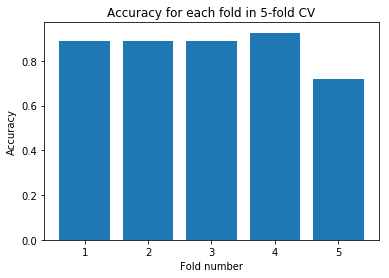

0.8625185185185185


In [67]:
# cross validation
rf.fit(X_train, y_train)

scores = cross_val_score(rf, X_scaled, y, cv=5)
print(scores)
plt.bar(range(1,6),scores)
plt.title('Accuracy for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('Accuracy')
plt.show()
print(scores.mean())

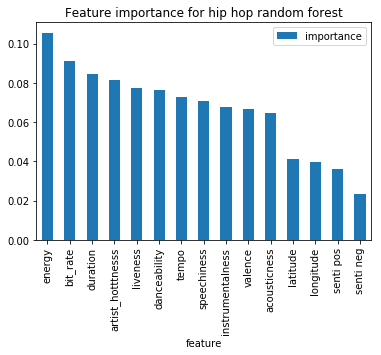

                   importance
feature                      
energy               0.105515
bit_rate             0.090959
duration             0.084650
artist_hotttnesss    0.081658
liveness             0.077608


In [68]:
importances = pd.DataFrame({'feature':Hiphop_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':rf.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for hip hop random forest')
plt.show()
print(importances[:5])

# kNeighborsClassifier

In [69]:
# scale the data and split to train - test sets
y = Hiphop_10[['popular']].values.ravel()
X=Hiphop_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).astype(float).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

In [70]:
#Run grid search for best parameters
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = { 'n_neighbors' : np.arange(2,10)}
CV_rfc = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'n_neighbors': 5}

In [71]:
# run knn classifier
knn = KNeighborsClassifier(n_neighbors=CV_rfc.best_params_['n_neighbors'])
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)

acc_knn = knn.score(X_test, y_test) * 100
print(acc_knn)

81.48148148148148


In [72]:
#Cross Validation

knn = KNeighborsClassifier(n_neighbors = CV_rfc.best_params_['n_neighbors'])
scores = cross_val_score(knn, X_scaled, y, cv=5, scoring = "roc_auc")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.65277778 0.65277778 0.98611111 1.         0.84782609]
Mean: 0.8278985507246377
Standard Deviation: 0.15256592020632134


[0.65277778 0.65277778 0.98611111 1.         0.84782609]


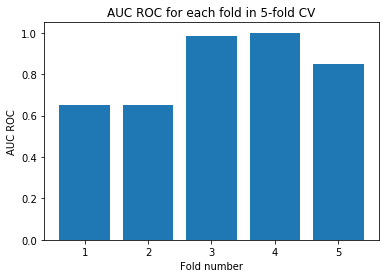

In [73]:
# cross validation
scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

[0.92592593 0.88888889 0.88888889 0.96296296 0.72      ]


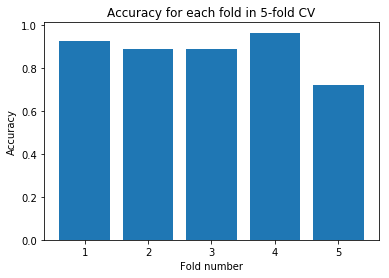

In [74]:
# cross validation
scores = cross_val_score(knn, X_scaled, y, cv=5)
print(scores)
plt.bar(range(1,6),scores)
plt.title('Accuracy for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('Accuracy')
plt.show()

For hip-hop music, across our models, artist hottness, bit rate, and energy appear most often as important features. This tells us that for hip-hop, the perceived popularity of the artist, the sound quality of the song (as indicated by bit rate), and the energy in the song are strong indicators of a song's popularity. We see that our logistic regression with an L1 penalty of $C=0.45$ performs best on random subsets of data (with an AUC ROC of about 0.9), so we select this model for hip-hop.

# Electronic Music

In [75]:
# scale the data and split to train - test sets
y = Elec_10[['popular']].values.ravel()
X=Elec_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).astype(float).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

# Logistic Regression

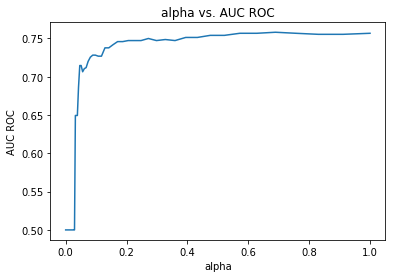

Optimal C value for logistic regression: 1.6297508346206435


In [76]:
# L1 penalty
C_vals = np.logspace(-4,0,100)
scores = []
for C_val in C_vals:
    
    #change penalty to l1
    regr = LogisticRegression(penalty='l1', C = C_val)
    regr.fit(X_train, y_train)
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    scores.append(roc_auc)
    
#plot alphas vs. scores
plt.plot(C_vals, scores)
plt.xlabel('alpha')
plt.ylabel('AUC ROC')
plt.title('alpha vs. AUC ROC')
plt.show()

C_best_L1 = C_vals[scores.index(max(scores))]
print('Optimal C value for logistic regression: ' + str(C_best))

Area under the ROC curve : 0.758152


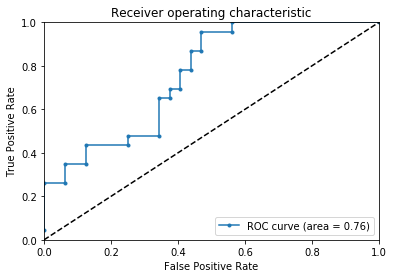

In [77]:
# Train logistic regression for popularity
from sklearn.linear_model import LogisticRegression
regr = LogisticRegression(penalty='l1',C=C_best_L1)
regr.fit(X_train, y_train)

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

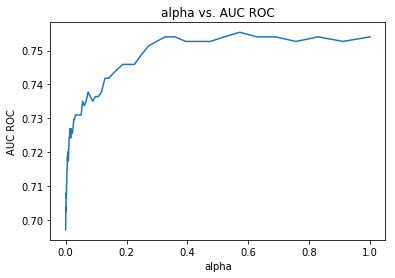

Optimal C value for logistic regression: 0.572236765935022


In [78]:
#L2 penalty
C_vals = np.logspace(-4,0,100)
scores = []
for C_val in C_vals:
    
    #change penalty to l2
    regr = LogisticRegression(penalty='l2', C = C_val)
    regr.fit(X_train, y_train)
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    scores.append(roc_auc)
    
#plot alphas vs. scores
plt.plot(C_vals, scores)
plt.xlabel('alpha')
plt.ylabel('AUC ROC')
plt.title('alpha vs. AUC ROC')
plt.show()

C_best = C_vals[scores.index(max(scores))]
print('Optimal C value for logistic regression: ' + str(C_best))

Area under the ROC curve : 0.755435


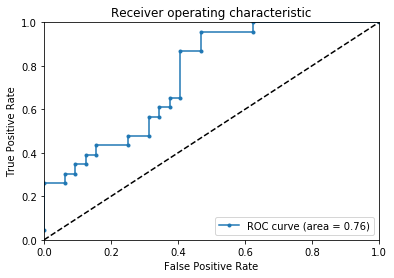

In [79]:
# Train logistic regression for popularity
from sklearn.linear_model import LogisticRegression
regr = LogisticRegression(penalty='l2',C=C_best)
regr.fit(X_train, y_train)

#compute ROC 
probas_ = regr.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l2 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

[0.436      0.74133333 0.89241379 0.55172414 0.80890805]
0.6860758620689655


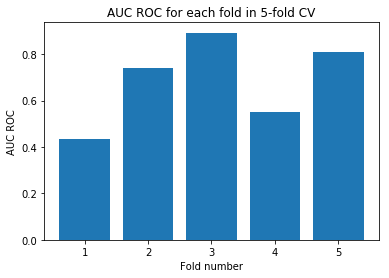

In [80]:
# Choose L1 penalty since we want to have more variables -> 0 - perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = LogisticRegression(C=C_best_L1, penalty='l1')
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
print(np.mean(scores))
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

[0.54545455 0.65454545 0.7962963  0.57407407 0.75471698]
0.6650174703004892


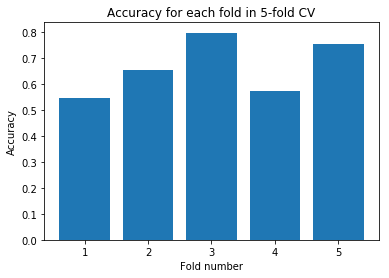

In [81]:
# Choose L1 penalty since we want to have more variables -> 0 - perform 5-fold cross-validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = LogisticRegression(C=C_best_L1, penalty='l1')
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5)
print(scores)
print(np.mean(scores))
plt.bar(range(1,6),scores)
plt.title('Accuracy for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('Accuracy')
plt.show()

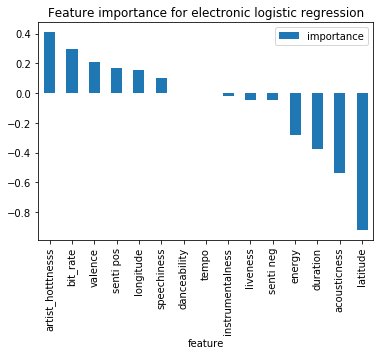

                   importance
feature                      
artist_hotttnesss    0.408044
bit_rate             0.293857
valence              0.205607
senti pos            0.165376
longitude            0.156614


In [82]:
importances = pd.DataFrame({'feature':Elec_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.coef_[0]})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for electronic logistic regression')
plt.show()
print(importances[:5])

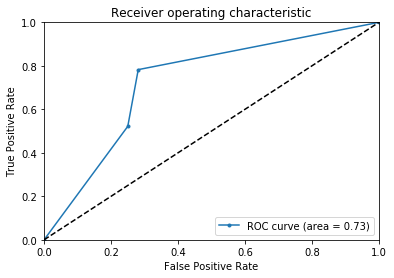

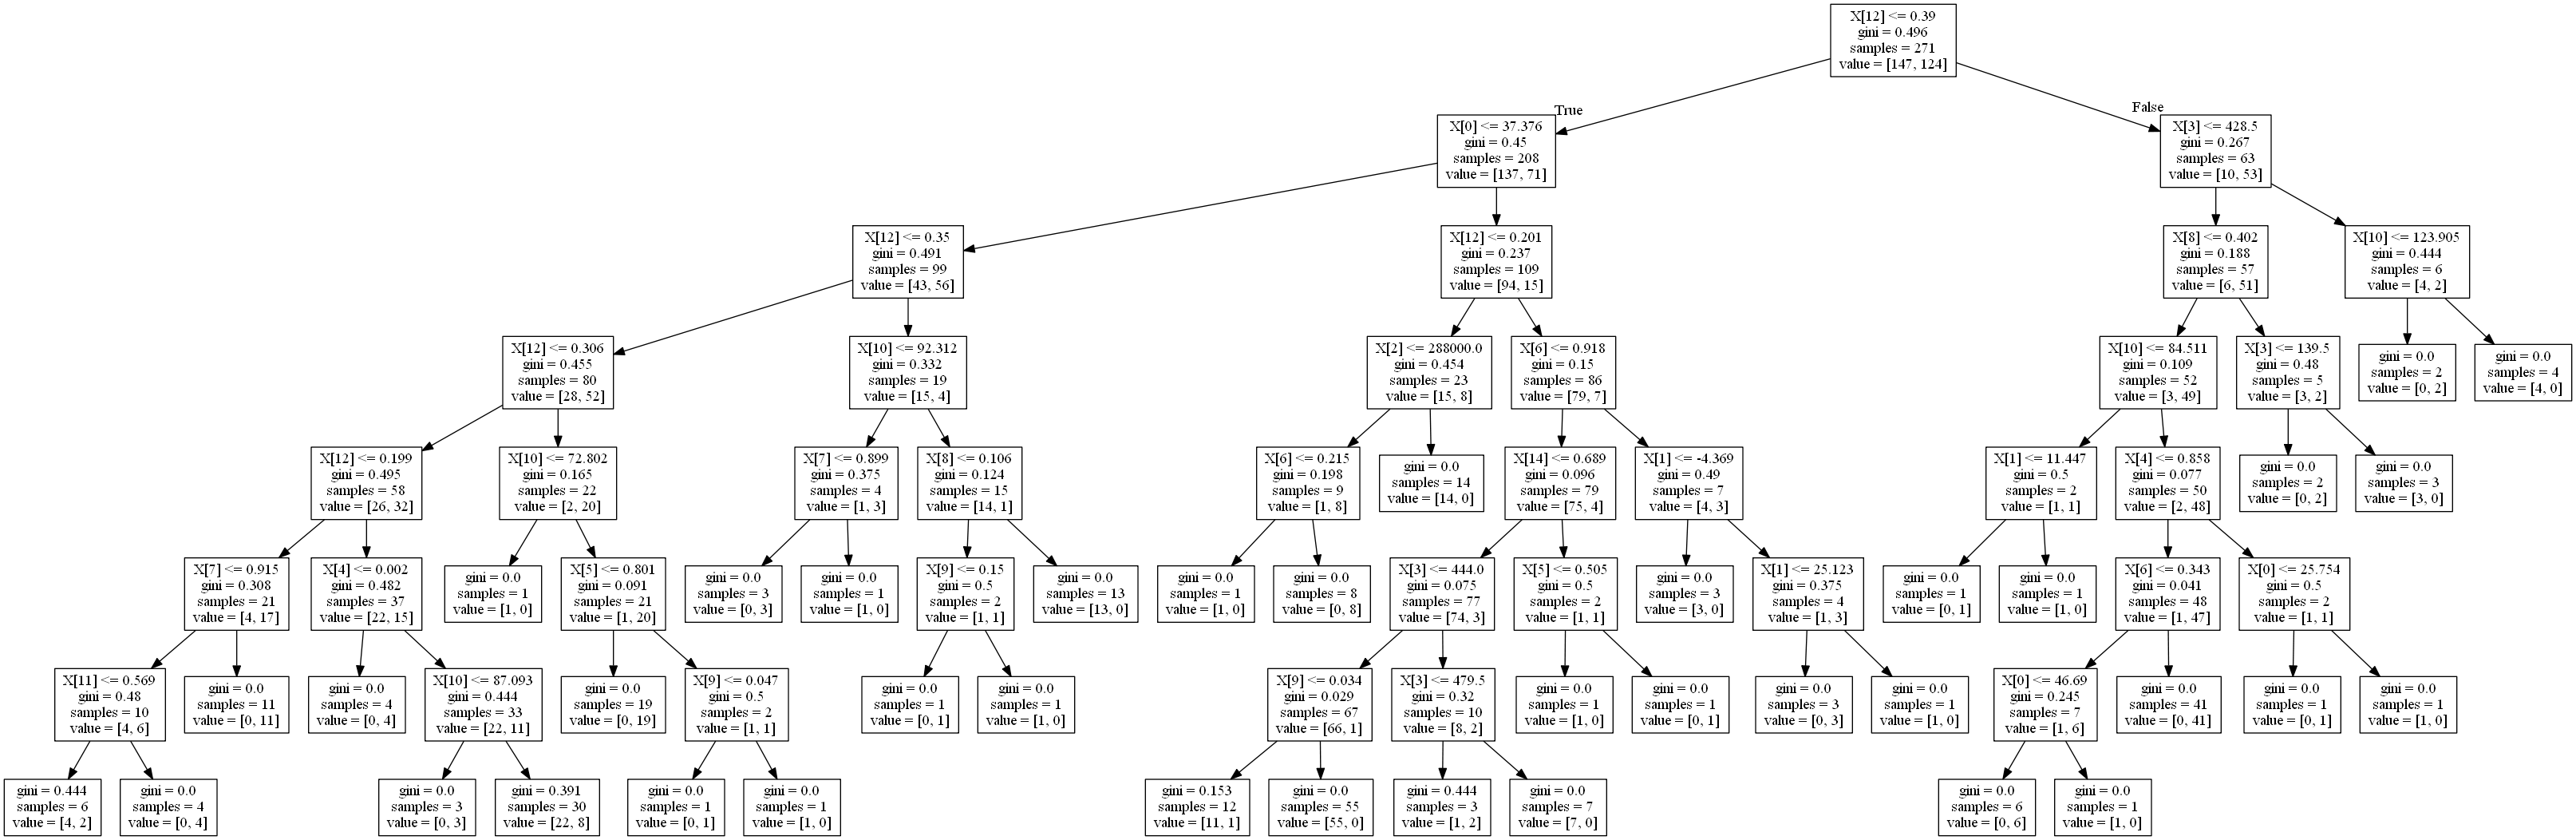

In [83]:
#Visualize the decision tree
# Import the necessary modules and libraries
import os
import subprocess
import pandas as pd
from PIL import Image, ImageFilter
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from sklearn.utils import shuffle
from IPython.display import Image

random_state = np.random.RandomState(0)
regr_7 = DecisionTreeClassifier(max_depth=7)
dt = regr_7.fit(X_train, y_train)

probas_ = regr_7.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)

#Visualize
pydotplus.find_graphviz()
regr = DecisionTreeClassifier(max_depth=7)
regr = regr.fit(X, y)
dot_file = open('dt.dot','w')
export_graphviz(regr, out_file='dt.dot')

os.system("dot -Tpng dt.dot -o dtree.png")
im = Image('dtree.png')
im.format = "png"
display(im)

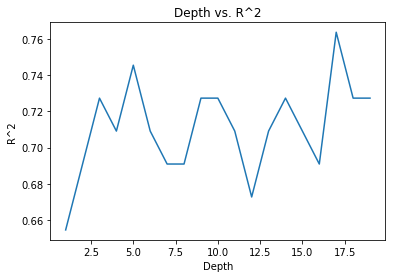

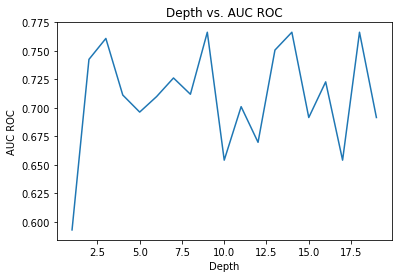

Optimal depth: 9


In [84]:
#check for different tree depths 
train_errors=[]
test_errors=[]
scores=[]
auc_rocs = []

depths = range(1,20)
for n in depths:
    regr = DecisionTreeClassifier(max_depth=n)
    
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    scores.append(regr.score(X_test,y_test))
    
    probas_ = regr.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    
    auc_rocs.append(roc_auc)
    
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.title('Depth vs. R^2')
plt.plot(depths,scores)
plt.show()

plt.ylabel('AUC ROC')
plt.xlabel('Depth')
plt.title('Depth vs. AUC ROC')
plt.plot(depths,auc_rocs)
plt.show()

test_errors=scores
n_opt=depths[np.argmax(auc_rocs)]

print('Optimal depth: ' + str(n_opt))

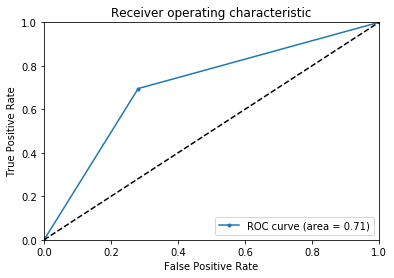

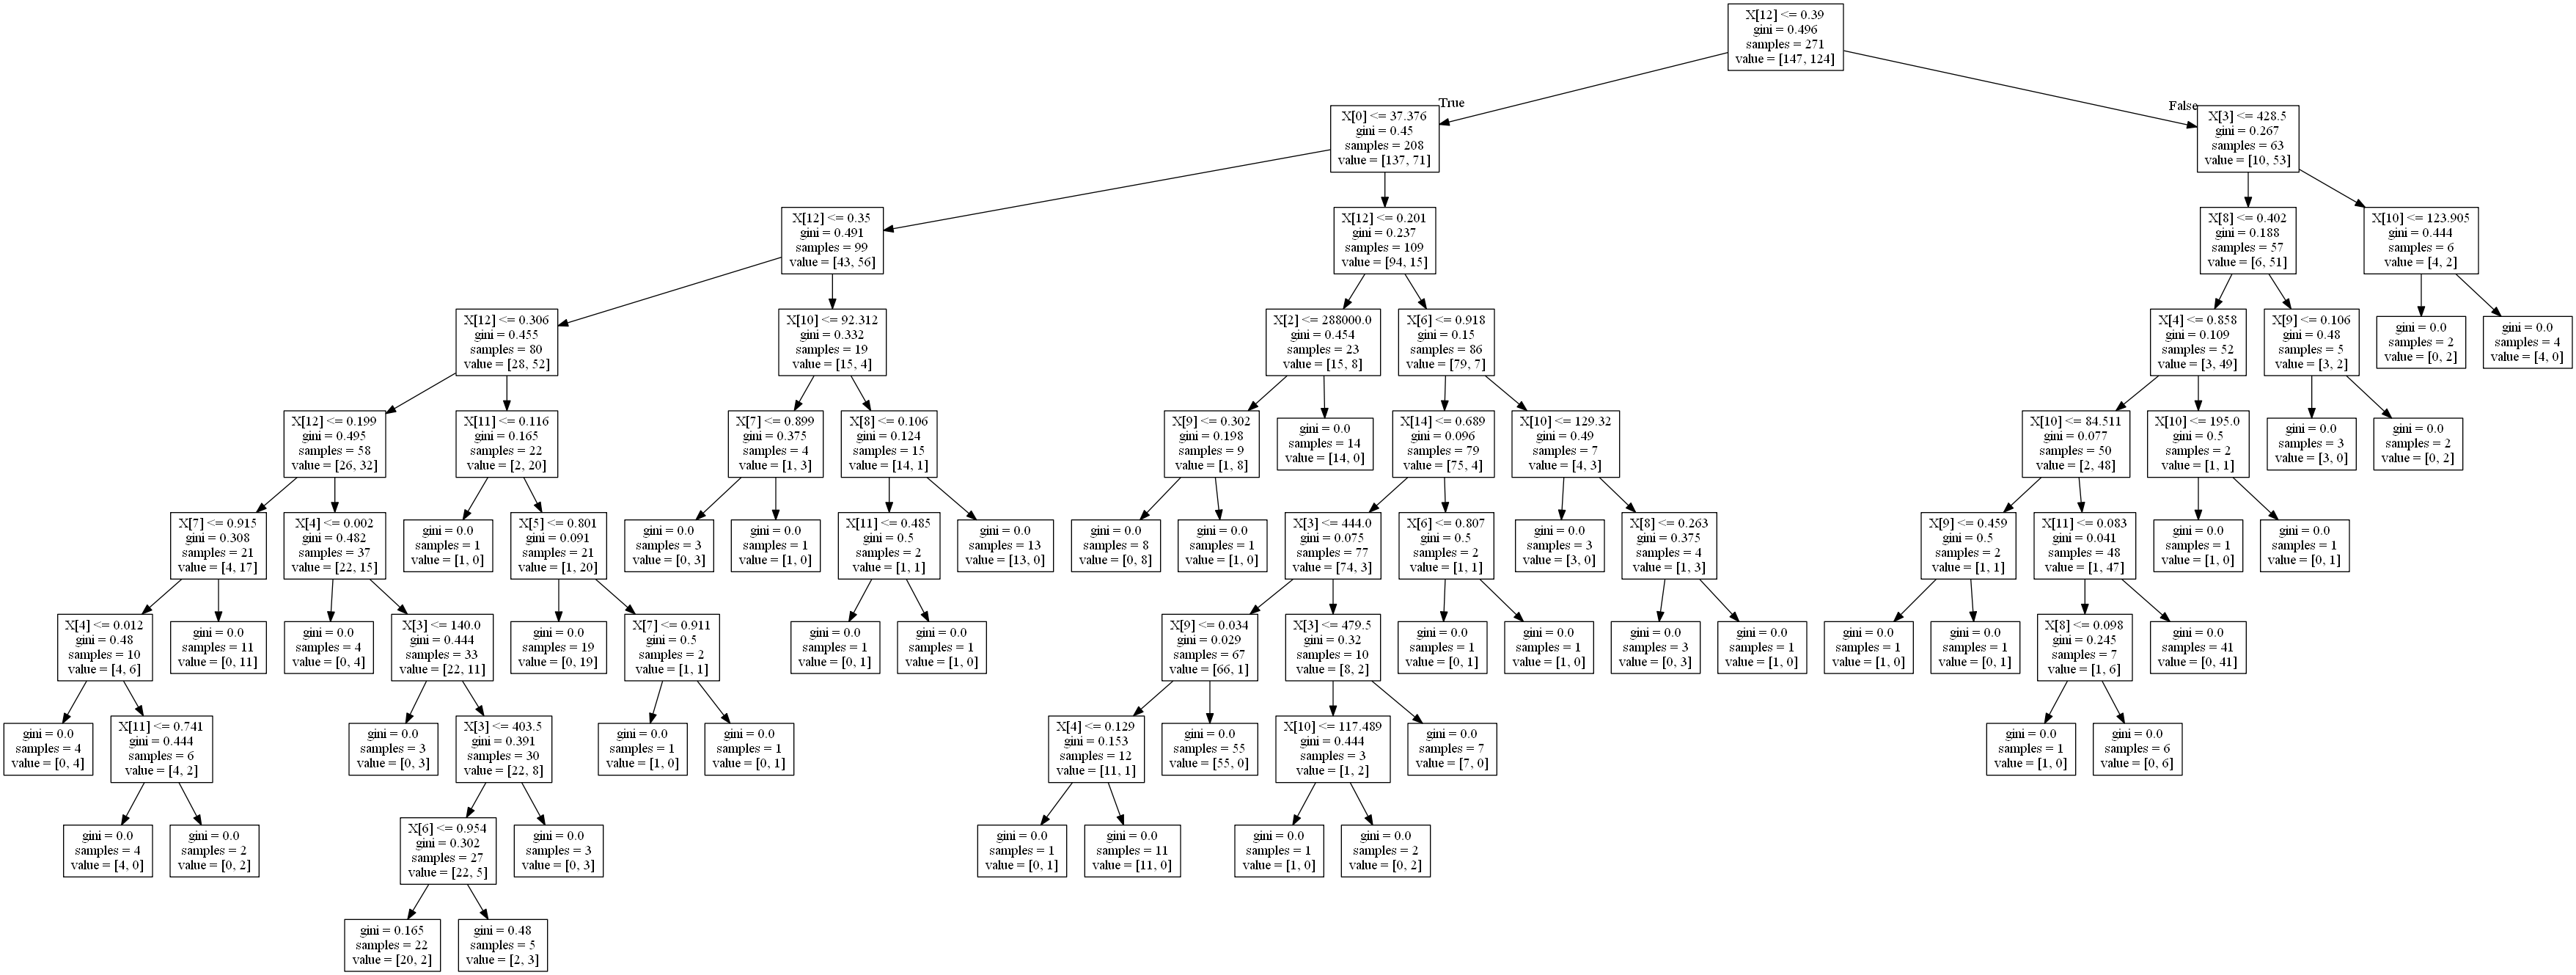

In [85]:
# Fit decision tree classifier with optimal depth
regr_opt = DecisionTreeClassifier(max_depth=n_opt)
regr_opt.fit(X_train, y_train)

probas_ = regr_opt.fit(X_train, y_train).predict_proba(X_test)
    
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
    
generate_ROCplot(fpr,tpr,'LR',roc_auc)

# Visualize
pydotplus.find_graphviz()
regr = DecisionTreeClassifier(max_depth=n_opt)
regr = regr.fit(X, y)
dot_file = open('dt.dot','w')
export_graphviz(regr, out_file='dt.dot')

os.system("dot -Tpng dt.dot -o dtree.png")
im = Image('dtree.png')
im.format = "png"
display(im)

[0.61666667 0.63333333 0.62413793 0.45586207 0.36422414]


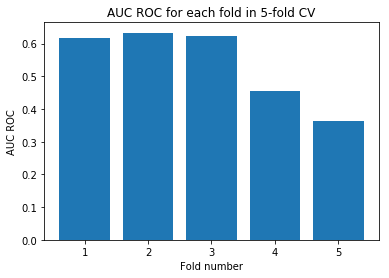

0.538844827586207


In [86]:
# test on random folds - cross validation
from sklearn.model_selection import cross_val_score

# cross validation
regr = DecisionTreeClassifier(max_depth=n_opt)
regr.fit(X_train, y_train)

scores = cross_val_score(regr, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

print(np.mean(scores))

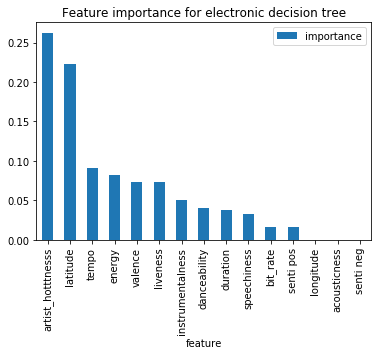

                   importance
feature                      
artist_hotttnesss    0.262240
latitude             0.222799
tempo                0.091398
energy               0.082633
valence              0.073165


In [87]:
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':regr.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for electronic decision tree')
plt.show()
print(importances[:5])

# Random Forest

76.36363636363637
                   importance
feature                      
artist_hotttnesss    0.160731
latitude             0.106114
longitude            0.088456
acousticness         0.081704
duration             0.077124


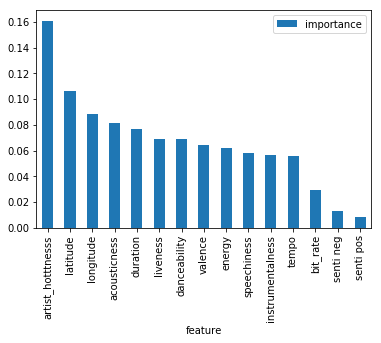

In [88]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_test, y_test)
acc_random_forest = random_forest.score(X_test, y_test) * 100
print(acc_random_forest)
importances = pd.DataFrame({'feature':Rock_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':random_forest.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
print(importances[:5])

In [89]:
#check for different tree depths 
from sklearn.model_selection import GridSearchCV

rfc=RandomForestClassifier()
param_grid = { 'max_depth' : np.arange(1,10), 'max_features' : np.arange(1,10)}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'max_depth': 3, 'max_features': 4}

Area under the ROC curve : 0.834239


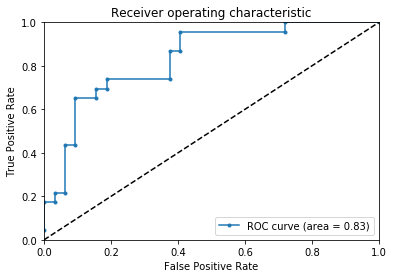

In [90]:
#roc auc for random forest
random_forest = RandomForestClassifier(n_estimators=100,max_depth=CV_rfc.best_params_['max_depth'],max_features=CV_rfc.best_params_['max_features'])
random_forest.fit(X_train, y_train)

#compute ROC 
probas_ = random_forest.fit(X_train,y_train).predict_proba(X_test)

# Generate ROC  for LR with l1 penalty
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

In [91]:
#Cross Validation
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100,max_depth=CV_rfc.best_params_['max_depth'],max_features=CV_rfc.best_params_['max_features'])
scores = cross_val_score(rf, X_scaled, y, cv=5, scoring = "roc_auc")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.46533333 0.83733333 0.73931034 0.44275862 0.45977011]
Mean: 0.5889011494252874
Standard Deviation: 0.1659174156069552


[0.47733333 0.85333333 0.72965517 0.43310345 0.48850575]


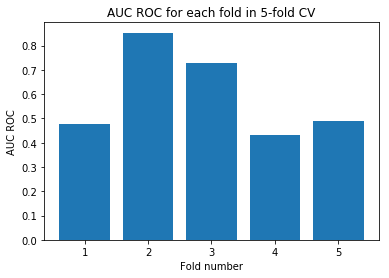

In [92]:
# cross validation
rf.fit(X_train, y_train)

scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

[0.56363636 0.70909091 0.72222222 0.46296296 0.49056604]


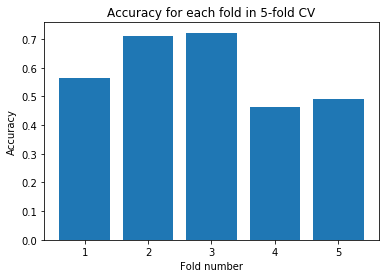

In [93]:
# cross validation
rf.fit(X_train, y_train)

scores = cross_val_score(rf, X_scaled, y, cv=5)
print(scores)
plt.bar(range(1,6),scores)
plt.title('Accuracy for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('Accuracy')
plt.show()

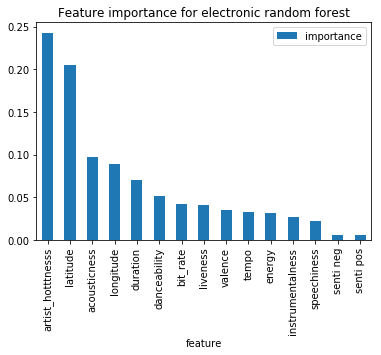

                   importance
feature                      
artist_hotttnesss    0.242886
latitude             0.204815
acousticness         0.097454
longitude            0.089276
duration             0.070562


In [94]:
importances = pd.DataFrame({'feature':Elec_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).columns,'importance':rf.feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()
plt.title('Feature importance for electronic random forest')
plt.show()
print(importances[:5])

# kNeighborsClassifier

In [95]:
# scale the data and split to train - test sets
y = Elec_10[['popular']].values.ravel()
X=Elec_10.drop(['track_listens','track_ID','popular','artist_discovery','artist_familiarity'],axis=1).astype(float).values
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=7)

In [96]:
#Run grid serach for best parameters
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_grid = { 'n_neighbors' : np.arange(2,10)}
CV_rfc = GridSearchCV(estimator=knn, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'n_neighbors': 7}

In [97]:
# run knn classifier
knn = KNeighborsClassifier(n_neighbors=CV_rfc.best_params_['n_neighbors'])
knn.fit(X_train, y_train)

Y_pred = knn.predict(X_test)

acc_knn = knn.score(X_test, y_test) * 100
print(acc_knn)

74.54545454545455


In [98]:
#Cross Validation
knn = KNeighborsClassifier(n_neighbors = CV_rfc.best_params_['n_neighbors'])
scores = cross_val_score(knn, X_scaled, y, cv=5, scoring = "roc_auc")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.47333333 0.78266667 0.78965517 0.48413793 0.60704023]
Mean: 0.6273666666666667
Standard Deviation: 0.13791994171869676


[0.47333333 0.78266667 0.78965517 0.48413793 0.60704023]


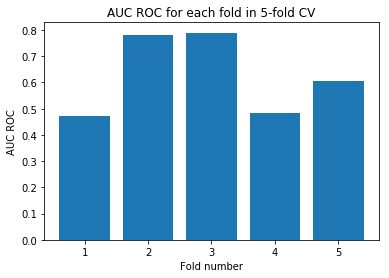

In [99]:
# cross validation
knn.fit(X_train, y_train)

scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='roc_auc')
print(scores)
plt.bar(range(1,6),scores)
plt.title('AUC ROC for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('AUC ROC')
plt.show()

[0.50909091 0.63636364 0.7037037  0.5        0.56603774]


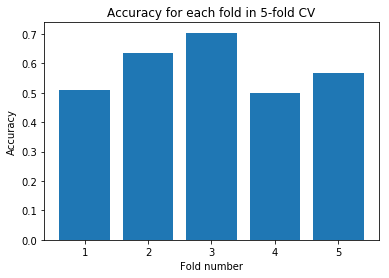

In [100]:
# cross validation
knn.fit(X_train, y_train)

scores = cross_val_score(knn, X_scaled, y, cv=5)
print(scores)
plt.bar(range(1,6),scores)
plt.title('Accuracy for each fold in 5-fold CV')
plt.xlabel('Fold number')
plt.ylabel('Accuracy')
plt.show()

For electronic music, across our models, artist hottness, latitude, and acousticness appear most often as important features. This tells us that for electronic, the perceived popularity of the artist, the location of where the song was made (latitude indicates north/south direction), and the acoustic nature of the song are strong indicators of a song's popularity. We see that our logistic regression with an L1 penalty of $C=1.63$ performs best on random subsets of data (with an AUC ROC of about 0.7), so we select this model for electronic music.